# Applied Statistical Learning - MS FGR

## Prédiction de ratios de Sharpe pour un ensemble de stratégies quantitatives

## 1. Sujet

### 1.1. Contexte

Le sujet que nous avons choisi de traiter concerne la prédiction du ratio de Sharpe d'un mix de stratégies quantitatives. Ce projet est proposé dans l'un des *Challenge Data du Collège de France* de Napoleon X. Le challenge est disponible au lien suivant : https://challengedata.ens.fr/participants/challenges/13/

Napoleon Crypto, branche de Napoleon X, est une entreprise spécialisée dans la conception de solutions d'investissement quantitatives, basées sur des algorithmes. Ayant développé plusieurs stratégies performantes, elle cherche à optimiser l'allocation entre ces stratégies pour maximiser les performances. L'objectif de ce problème est donc d'aider à la construction d'un **mélange optimal de stratégies quantitatives d'investissement** à partir de l'ensemble des stratégies soumises. C'est un enjeu absolument central pour tout fonds multi-stratégies, puisqu'il faut chercher à investir plus fortement dans les stratégies performantes, naturellement.

Trouver la meilleure allocation parmi les stratégies quantitatives chaque semaine revient à déterminer la combinaison maximisant le ratio de Sharpe (sur les 5 prochains jours de trading). Le ratio de Sharpe est une métrique de performance qui mesure le rendement excédentaire pour chaque point de risque pris. Il permet d'ajuster la performance au risque, et une combinaison optimale de stratégies devrait permettre d'obtenir un ratio de Sharpe "total" supérieur au ratio de Sharpe de chaque stratégie prise individuellement. Nous supposerons un taux sans risque nul. Avec $Lr_{i,s} = \ln \left( \frac{I_s}{I_{s-1}} \right)$ les rendements logarithmiques d'une stratégie $i$ à un temps $s$ (avec une valeur de la stratégie au temps $s$ qui vaut $I_s$), le ratio de Sharpe annualisé objectif est calculé selon la formule suivante, légèrement modfiée pour éviter une volatilité trop proche de 0 :
$$
S_t^*(w_1, \ldots, w_7) = \frac{\frac{252}{5} \sum_{i=1}^{7} w_i \times \left( \sum_{s=t+1}^{t+5} Lr_{i,s} \right)}{Max \left( \sqrt{252 \times \sum_{i=1}^{7} \sum_{j=1}^{7} w_i w_j \sum_{s=t-20}^{t+5} (Lr_{i,s} - \bar{Lr_i})(Lr_{j,s} - \bar{Lr_j})} ; 0.005 \right)}
$$

L'enjeu est donc, finalement, de prédire le ratio de Sharpe $S^*$ d'une combinaison donnée sur les 5 prochains jours de trading. Avec les outils de machine learning, nous allons chercher à prévoir ce ratio de Sharpe.

### 1.2. Description des données


Pour répondre à ce sujet, Napoleon X nous fournit des données concernant 7 stratégies quantitatives qu'ils ont mis en place. Pour chaque stratégie et chaque observation ("sample") nous sont fournis les poids alloués à chaque stratégie, la valeur de chacune des stratégies sur 21 jours de trading, et les valeurs de 3 instruments financiers (inconnus) sur 21 jours de trading. Toutes les séries temporelles sont alignées sur une même échelle de temps de 21 jours de trading et sont normalisées à 100 au départ, assurant la comparabilité entre échantillons. Naturellement, l'évolution des valeurs dépend de la stratégie ou de l'instrument.

Sur un même ensemble de 21 jours de trading, il peut y avoir jusqu'à 50 échantillons différents, avec les mêmes séries temporelles mais des poids différents. Autrement dit, nous pouvons avoir jusqu'à 50 échantillons sur les mêmes 21 jours, mais même si les valeurs des stratégies seront identiques (car normalisées à 100 au départ), les ratios de Sharpe seront différents en raison des poids différents. La présence de multiples échantillons sur une même période temporelle nécessitera un travail rigoureux lors de la séparation du dataset et de la cross-validation pour éviter le *data-leakage*.

Les données des features (10 000 samples) sont constitués des poids alloués aux stratégies, des valeurs des stratégies et des valeurs des instruments financiers, elles représentent les *features* initiales. Les valeurs du label sont les ratios de Sharpe, au nombre de 10 000 (1 par sample).

Les features sont organisées de la façon suivante :
- la première colonne correspond à l'ID de l'observation,
- les 7 colonnes suivantes correspondent aux poids alloués aux 7 stratégies qui nous sont proposées,
- les colonnes suivantes correspondent aux valeurs des autres *features* sur 21 jours de trading (séries temporelles). On a donc 21 colonnes par stratégie et par produit financier, soit un total de :
$$
\underbrace{1}_{ID} + \underbrace{7}_{\text{Poids}} + \underbrace{7 \times 21}_{\text{Valeurs des stratégies sur 21 jours}} + \underbrace{3 \times 21}_{\text{Valeurs des instruments sur 21 jours}} = 218 \text{ colonnes}  
$$
Les valeurs des stratégies et des instruments financiers sont normalisées à 100 au départ ($lag_{21}$). Les poids sont strictement positifs et somment à 1. Matriciellement, notre ensemble d'entraînement se représente par :
$$
X =
\begin{bmatrix}
w_1^{(1)} & w_2^{(1)} & \dots & w_7^{(1)} & I_1^{(1,t-20)} & I_1^{(1,t-19)} & \dots & I_1^{(1,t)} & \dots & I_7^{(1,t-20)} & \dots & I_7^{(1,t)} & X_1^{(1,t-20)} & \dots & X_3^{(1,t)} \\
w_1^{(2)} & w_2^{(2)} & \dots & w_7^{(2)} & I_1^{(2,t-20)} & I_1^{(2,t-19)} & \dots & I_1^{(2,t)} & \dots & I_7^{(2,t-20)} & \dots & I_7^{(2,t)} & X_1^{(2,t-20)} & \dots & X_3^{(2,t)} \\
\vdots & \vdots & \dots & \vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
w_1^{(10000)} & w_2^{(10000)} & \dots & w_7^{(10000)} & I_1^{(10000,t-20)} & I_1^{(10000,t-19)} & \dots & I_1^{(10000,t)} & \dots & I_7^{(10000,t-20)} & \dots & I_7^{(10000,t)} & X_1^{(10000,t-20)} & \dots & X_3^{(10000,t)}
\end{bmatrix},
\ Y = \begin{bmatrix}
SR_1 \\
SR_2 \\
\vdots \\
SR_{10000}
\end{bmatrix}
$$

## 2. Récupération et préparation des données

### 2.1. Import des bibliothèques nécessaires et création des fonctions élémentaires

In [ ]:
from itertools import combinations

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import random

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV, ParameterSampler, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

from scipy import stats
from scipy.stats import kruskal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from typing import Tuple,Optional

from types import SimpleNamespace

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor




Le bloc suivant définit l’ensemble des paramètres globaux du projet (données, validation croisée, reproductibilité et entraînement des modèles) afin d’assurer cohérence et reproductibilité des expériences.

In [47]:
cfg = SimpleNamespace(
    id_col="ID",            # identifiant
    target_col="Target",    # variable cible
    seed=42,                # graine aléatoire
    epochs=100,             # époques MLP
    patience=10,            # early stopping
    verbose_fit=0,          # verbosité entraînement
    n_iter_fast=10,         # recherche rapide
    n_iter_strong=20        # recherche approfondie
)

GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.keras.utils.set_random_seed(GLOBAL_SEED)


### 2.2 Import des données et nettoyage

In [48]:
features: pd.DataFrame = pd.read_csv("data/Training_Input.csv")
labels: pd.DataFrame = pd.read_csv("data/Training_Output.csv")

Pour plus de simplicité, on passe la première colonne ("ID") en index.

In [49]:
features = features.set_index('ID')
labels = labels.set_index('ID')

Nous effectuons quelques vérifications pour nous assurer que le jeu de données est utilisable :
- gestion des données manquantes
- gestion des données dupliquées
- uniformisation des formats de données
- gestion des outliers

Nous commençons par vérifier que les fichiers ne présentent pas de lignes dupliquées. Nous savons que les mêmes 21 jours peuvent être utilisés dans 50 samples au maximum, et cela sera pris en compte dans la suite. Il faut néanmoins s'assurer que nous n'avons jamais deux fois la même ligne, ce qui comprend donc également les poids (qui doivent être différents si la série temporelle est réutilisée).

In [50]:
print(f"Les dimensions du train set initial sont {features.shape} et celles du train set sans doublons sont de {features.drop_duplicates().shape}.")

Les dimensions du train set initial sont (10000, 217) et celles du train set sans doublons sont de (9933, 217).


Nous supprimons les doublons identifiés. Nous devons procéder aux suppressions des IDs correspondant dans le tableau contenant les labels.

In [51]:
features = features.drop_duplicates()
labels = labels.loc[features.index]

# On vérifie que les dimensions sont cohérentes
print(f"Dimensions du dataset après suppression des doublons: {features.shape}")
print(f"Dimensions des labels correspondants: {labels.shape}")

Dimensions du dataset après suppression des doublons: (9933, 217)
Dimensions des labels correspondants: (9933, 1)


Cela étant fait, nous devons maintenant traiter les valeurs manquantes, s'il y en a.

In [52]:
print(f"Le fichier contenant les features contient {features.isnull().sum().sum()} données manquantes.")
print(f"Le fichier contenant les valeurs cibles contient {labels.isnull().sum().sum()} données manquantes.")

Le fichier contenant les features contient 0 données manquantes.
Le fichier contenant les valeurs cibles contient 0 données manquantes.


Il n'y a aucune valeur manquante dans nos données, aucun traitement particulier n'est nécessaire. Nous pouvons désormais effectuer quelques vérifications sur les valeurs :
- les valeurs des parts doivent être comprises entre 0 et 1 (ce sont des fractions de l'*asset under management* total)
- la somme des parts doit être égale à 1 (tolérance de $10^{-4}$)
- les valeurs initiales (au temps $t-20$) des stratégies et des instruments financiers doivent être normalisées à 100 (initialisation)

In [53]:
features = features.astype(float)
labels = labels.astype(float)

# Tests sur les poids : compris entre 0 et 1 et somment à 1
# On récupère les noms des colonnes de poids
weights_columns = features.columns[:7]

# Ensemble des features
print(f"Dans le set des features, {((features[weights_columns] < 0) | (features[weights_columns] > 1)).sum().sum()} samples présentent de poids supérieurs à 1 ou inférieurs à 0")
print(f"Dans le set des features, {abs((features[weights_columns].sum(axis=1) - 1)> 0.0001).sum()} samples ont une somme totale de poids différents de 1")

# Tests sur les valeurs initiales
cols_lag_20 = [col for col in features.columns if "lag_20" in col]
print(f"Dans le set des features,, {((features[cols_lag_20] != 100)).sum().sum()} samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100")


Dans le set des features, 0 samples présentent de poids supérieurs à 1 ou inférieurs à 0
Dans le set des features, 0 samples ont une somme totale de poids différents de 1
Dans le set des features,, 0 samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100


Nous avons donc bien un jeu de données cohérent : les poids sont positifs, inférieurs à 1 et somment à 1, et les valeurs des stratégies sont initialisées à 100.

### 2.3. Analyse et traitement du dataset entier

#### 2.3.1. Etudes descriptives des features

Nous pouvons d'abord présenter différentes statistiques descriptives concernant les features. On conserve volontairement les poids (pour observer une éventuelle surpondération systématique d'une stratégie, qui viendrait biaiser la procédure), et excluons les colonnes dont le nom contient `'lag_20'`, invariantes et fixées à 100  :

In [54]:
descriptive_features= features.drop(columns= cols_lag_20).describe()
display(descriptive_features)

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_9,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0
count,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,...,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000
mean,0.140386,0.142948,0.137516,0.144443,0.146114,0.141730,0.146864,100.003134,100.041772,100.035278,...,100.145883,100.161612,100.219432,100.254470,100.265499,100.254483,100.280384,100.317989,100.297769,100.373786
std,0.240357,0.239658,0.236975,0.243246,0.242014,0.238503,0.242782,0.347090,0.465034,0.598440,...,1.219126,1.306254,1.378701,1.401333,1.449472,1.499794,1.581808,1.679319,1.709146,1.782651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.433199,98.207613,97.537396,...,95.431478,95.979716,95.979716,96.599608,96.478804,96.341153,96.449968,95.723877,95.642353,94.714651
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.941434,99.890905,99.890394,...,99.175035,99.278537,99.320099,99.314203,99.347147,99.187762,99.294802,99.266062,99.065229,99.283154
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.018707,100.039708,...,100.254695,100.247433,100.357552,100.385036,100.442787,100.475607,100.463374,100.578628,100.519780,100.645186
75%,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,100.096339,100.166922,100.296274,...,100.921678,101.000833,101.033472,101.132016,101.183649,101.217050,101.251502,101.272801,101.351743,101.468789
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.475880,101.350831,101.881236,...,103.869008,104.767236,105.458086,106.757012,106.549721,105.582424,107.157708,108.207867,108.207867,108.677631


Concentrons-nous d'abord sur les poids. On remarque que ces derniers semblent globalement équirépartis (moyenne à presque $0.14 \approx \frac{1}{7}$ pour les 7 stratégies). Cela est une bonne nouvelle, puisque la surpondération systématique d'une stratégie aurait réduit l'intérêt des poids dans le travail d'entraînement, alors que le coeur du sujet réside ici (si une stratégie est pondérée en moyenne à 80%, elle expliquera presque systématiquement le ratio de Sharpe). Par ailleurs, Les écarts-types des poids sont tous proches de 24 %, ce qui témoigne d’une variabilité relativement homogène. Cette variabilité uniforme est également rassurante, puisque nous n'avons pas des poids quasi-statiques d'une part, et instables d'autre part.  

Concentrons-nous ensuite sur les valeurs des stratégies et des instruments financiers. On s'attend à ce que la volatilité aille croissant avec le temps (puisque les scénarios possibles se démultiplient). Il peut également être intéressant d'observer l'évolution de la valeur moyenne dans le temps : si les stratégies sont performantes, la moyenne devrait aussi augmenter. Pour voir cela, nous allons afficher les moyennes et volatilités dans le temps pour chaque valeur de stratégie et d'instruments.

In [55]:
# Etape 1 : création des fonctions annexes
def extract_by_element_and_lag(stat: str = 'mean', desc_df: pd.DataFrame = descriptive_features) -> pd.DataFrame:
    """
    Fonction qui extrait une statistique spécifique pour chaque élément (stratégie ou instrument) à chaque lag.

    Inputs :
    -----------
    stat : Statistique à extraire ('mean', 'std', etc.)
    desc_df : DataFrame contenant les statistiques descriptives

    Output :
    --------
    DataFrame avec colonnes 'element', 'lag' et la statistique demandée
    """
    # On crée un dictionnaire contenant le nom de la stratégie (I_lag_nbre) ou la variable macroéconomique (X_lag_nbre),
    # le lag converti en entier et la statistique cherchée pour cet élément à ce lag.
    results = [
        {
            'element': col.split('_lag_')[0],
            'lag': int(col.split('_lag_')[1]),
            stat: desc_df.loc[stat, col]
        }
        for col in desc_df.columns if '_lag_' in col
    ]

    # On convertit le dictionnaire en dataframe
    result_df = pd.DataFrame(results)
    return result_df.sort_values(['element', 'lag'])

def create_line_chart(data: pd.DataFrame, stat: str, elements_I: list = None, elements_X: list = None,
                     title: str = None, y_label: str = None) -> plt.Figure:
    """
    Fonction qui crée un graphique linéaire montrant l'évolution d'une statistique dans le temps pour différents éléments.

    Inputs :
    -----------
    data : DataFrame contenant les données à plot, au format [stratégie ou instrument    lag    statistique]
    stat : Nom de la colonne contenant la statistique à visualiser
    elements_I : Liste des stratégies à inclure (toutes les stratégies par défaut)
    elements_X : Liste des instruments à inclure (tous les instruments par défaut)
    title : Titre du graphique
    y_label : Label de l'axe des ordonnées
    """
    # Valeurs par défaut
    if elements_I is None:
        elements_I = sorted([e for e in data['element'].unique() if e.startswith('I_')])
    if elements_X is None:
        elements_X = sorted([e for e in data['element'].unique() if e.startswith('X_')])
    if title is None:
        title = f"Évolution de {stat} dans le temps"
    if y_label is None:
        y_label = stat.capitalize()

    fig, ax = plt.subplots(figsize= (14, 8))

    # On distingue les stratégies des instruments
    colors_I = plt.cm.Blues(np.linspace(0.4, 0.9, len(elements_I)))
    colors_X = plt.cm.Reds(np.linspace(0.4, 0.9, len(elements_X)))

    # Stratégies
    for i, elem in enumerate(elements_I):
        subset = data[data['element'] == elem]
        ax.plot(subset['lag'], subset[stat], 'o-',
                label=elem, color=colors_I[i], linewidth=2)

    # Instruments
    for i, elem in enumerate(elements_X):
        subset = data[data['element'] == elem]
        ax.plot(subset['lag'], subset[stat], 's-',
                label=elem, color=colors_X[i], linewidth=2)

    # Personnalisation du graphique
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Lag (0 = plus récent, 19 = plus ancien)', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(range(0, 20))
    ax.invert_xaxis()  # Inverser l'axe x pour que le temps aille de gauche à droite
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    return fig

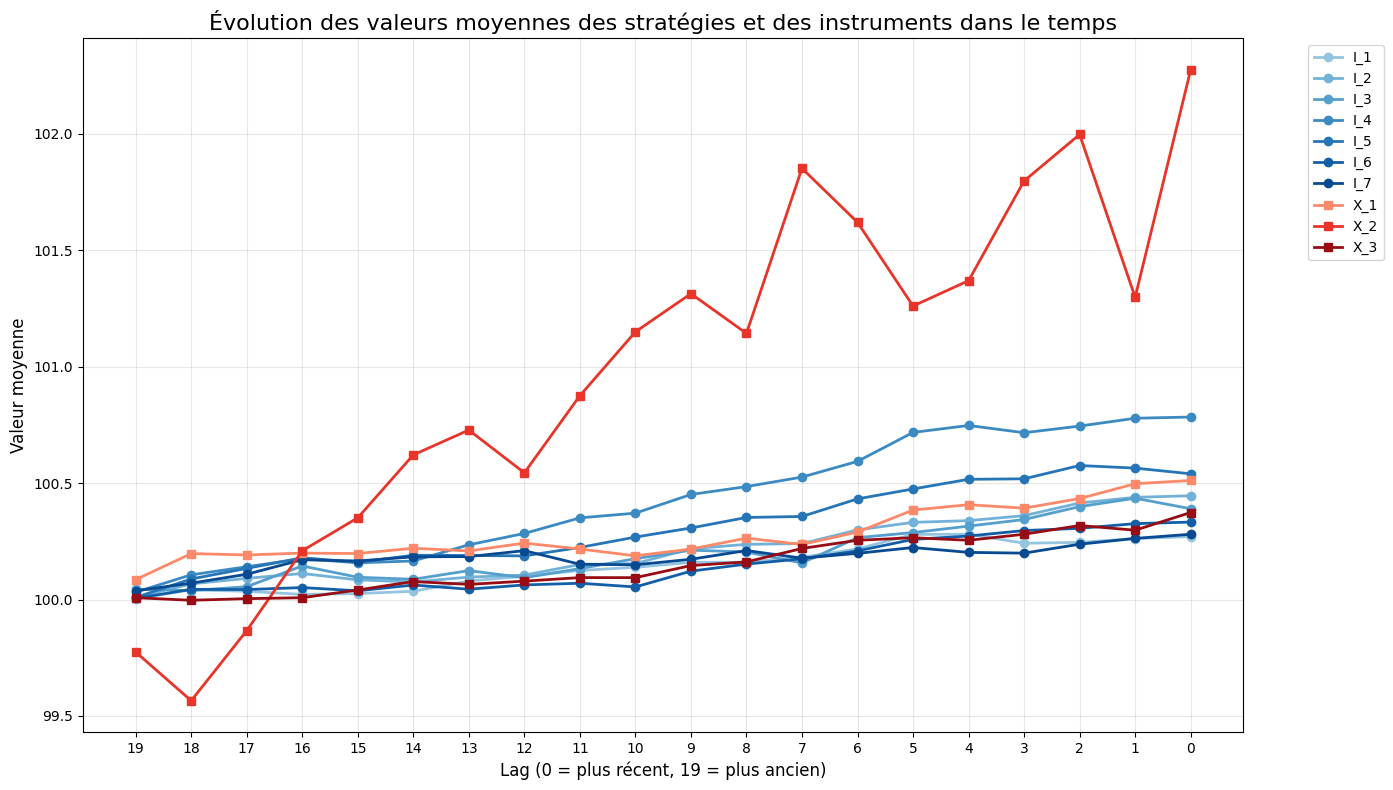

In [56]:
# Etape 2 : affichage
# Récupération des moyennes
means_by_element = extract_by_element_and_lag('mean', descriptive_features)

# On "inverse" les lags de sorte à ce que le graphique aille du plus ancien au plus récent
# 20 (données les plus anciennes) devient 0 par exemple
max_lag = means_by_element['lag'].max()
means_by_element['time'] = max_lag - means_by_element['lag']

# Eléments à visualiser
I_elements = [f'I_{i}' for i in range(1, 8)]
X_elements = [f'X_{i}' for i in range(1, 4)]

# Filtrage
filtered_means = means_by_element[means_by_element['element'].isin(I_elements + X_elements)]

# Création des graphiques et affichage
fig_means = create_line_chart(
    filtered_means,
    'mean',
    I_elements,
    X_elements,
    'Évolution des valeurs moyennes des stratégies et des instruments dans le temps',
    'Valeur moyenne'
)

plt.figure(fig_means.number)
plt.show()


On observe globalement des comportements fidèles à ceux attendus : les portefeuilles alloués aux différentes stratégies (I_1 à I_7) s'apprécient, de même que les valeurs des instruments (X_1 à X_3) qui sont inconnus. Cela témoigne d'une bonne performance des stratégies, tandis que l'interprétation des instruments est plus ardue, ceux-ci n'étant pas connus. L'instrument 2 (X_2) ressort évidemment, il offre un rendement sur 20 jours plus important en moyenne et semble plus volatile. Ces éléments nous confirment la nécessité de standardiser nos données afin d'équilibrer leur l'influence et d'éviter que des variables à forte dispersion ne dominent les algorithmes sensibles à l'échelle.

#### 2.3.2. Etudes descriptives de la variable cible



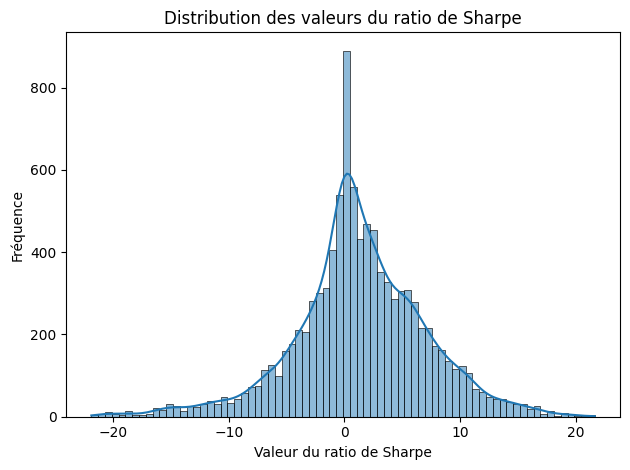

Skewness de la distribution des ratios de Sharpe : -0.26373135791649505
Excès de kurtosis de la distribution des ratios de Sharpe : 1.2519305744791578
===== Statistiques descriptives =====
count    9933.000000
mean        1.293375
std         5.806981
min       -21.902900
25%        -1.564104
50%         0.992727
75%         4.794639
max        21.665272
Name: Target, dtype: float64


In [57]:
# Histogramme
sns.histplot(labels["Target"], kde=True)
plt.xlabel("Valeur du ratio de Sharpe")
plt.ylabel("Fréquence")
plt.title('Distribution des valeurs du ratio de Sharpe')

plt.tight_layout()
plt.show()

# Skewness et kurtosis de la distribution des ratios de Sharpe
print(f"Skewness de la distribution des ratios de Sharpe : {labels['Target'].skew()}")
print(f"Excès de kurtosis de la distribution des ratios de Sharpe : {labels['Target'].kurt()}")

print("===== Statistiques descriptives =====")
print(labels["Target"].describe())

Ce graphique et ces valeurs nous permettent de faire plusieurs commentaires :
- La distribution des ratios de Sharpe est relativement symétrique mais légèrement décalée à gauche (skewness négatif),
- La distribution des ratios de Sharpe est leptokurtique, avec des queues de distribution plus épaisses qu'une distribution gaussienne. Cela est cohérent avec les faits stylisés des rendements financiers, qui ne suivent pas une distribution Normale.

Les ensembles de stratégies présentent un ratio de Sharpe annualisé moyen d'environ 1.3, ce qui se situe dans la tranche haute des valeurs usuelles des ratios de Sharpe. Cependant, l'élement le plus frappant reste la plage d'évolution de ce ratio, avec une étendue de plus de 40. On est donc face à des stratégies qui, certes, affichent de bonnes performances en moyenne, mais sont aussi très risquées. Cela se confirme par la volatilité du ratio de Sharpe.  Cette distribution étonnante, car beaucoup plus étalée (surpondération de valeurs intermédiaires et extrèmes) qu'une distribution de Sharpe classique souvent très compact autour de zéro, s'explique par plusieurs raisons. Tout d'abord la nature extrêmement volatile des cryptomonnaies, actifs principales des stratégies de Napoleon Crypto conduit à des stratégies volatiles et incertaines. Par ailleurs l'horizon considérée est extrèmement court (5 jours) ce qui renforce l'instabilité du ratio de Sharpe annualisé. 

#### 2.3.3. Corrélation entre les features

Intéressons-nous aux corrélations entre les features, des corrélations trop fortes entre les *features* (ou, comme nous raisonnons aussi avec des séries temporelles, des cas d'autocorrélation) peut réduire l'interprétabilité (difficile d'isoler l'effet individuel de chaque feature sur la prévision) et la performance du modèle (certains algorithmes sont sensibles à la multicolinéarité). En outre, cela peut aussi favoriser l'overfitting. Nous en profitons pour suprimer la colonne "lag_20" (identiques pour tout l'échantillon).

In [58]:
# Copies de sécurité
features_clean = features.copy()
labels_clean = labels.copy()

La représentation de la matrice de corrélation n'est pas simple étant donnée sa taille. Nous proposons deux approches :
- une approche par heatmap usuelle sur la partie triangulaire inférieure de la matrice. C'est une solution peu fine, mais elle permet de voir à vue d'oeil si les corrélations sont **globalement** fortes ou faibles entre les features ;
- un affichage de l'histogramme des corrélations. Si l'on s'aperçoit qu'un nombre conséquent de corrélations sont élevées, nous investiguerons davantage.
Nous procédons également au test de significativité des corrélations :
\begin{align*}
H_0 &: \rho_{X,Y} = 0 \\
H_1 &: \rho_{X,Y} \neq 0
\end{align*}

Avec $n$ le nombre d'observation, la statistique de test associée s'énonce :
\begin{align*}
t = \hat{\rho_{X,Y}} \times \sqrt{\frac{n-2}{1-\hat{\rho_{X,Y}}^2}} \sim St(n-2)
\end{align*}
Si la pvalue calculée est inférieure à 5% (seuil de risque de première espèce retenu), on rejette $H_0$. La fonction suivante traduit en code les éléments sus-mentionnés et permet de fournir l'analyse globale des corrélations de Pearson.

In [59]:
def pearson_pvalue(r: float, n: int) -> float:
        """
        Calcule la p-value pour un coefficient de corrélation de Pearson donné
        Inputs :
        ---------
        r : coefficient de corrélation
        n : nombre de samples / observations
        """
        if abs(r) == 1.0:
            return 0.0
        t = r * np.sqrt((n-2) / (1-r**2))
        p = 2 * (1 - stats.t.cdf(abs(t), n-2))
        return p

def analyze_correlations(df: pd.DataFrame,
                         alpha: float=0.05) -> Tuple[pd.DataFrame, float]:
    """
    Analyse complète des corrélations d'un ensemble de données :
    - Matrice de corrélation
    - Distribution des coefficients de corrélation
    - Test de significativité des corrélations et distribution des p-values
    La corrélation de Pearson est utilisée et le nombre de données est suffisamment grand pour que
    les hypothèses de normalité soient supposées (théorème central limite)
    Inputs :
        df : DataFrame à analyser
        alpha : Seuil de significativité, par défaut 0.05
    Outputs :
        Tuple contenant la matrice de corrélation et le pourcentage de corrélations significatives
    """
    # 1. Setup
    ## Matrice de corrélation
    corr_matrix = df.corr(method='pearson')

    ## Création du masque pour le triangle inférieur de la matrice de corrélation
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    mask_lower = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)

    ## 2. Affichage de la matrice de corrélation
    plt.figure(figsize=(15,12))
    sns.heatmap(corr_matrix, mask=mask_upper, cmap="coolwarm",
                annot=False, linewidths=0.5, vmin=-1, vmax=1)
    plt.title("Matrice de Corrélation (Triangle Inférieur)", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 3. Affichage de la distribution des coefficients de corrélation
    corr_values = corr_matrix.values[mask_lower]
    plt.figure(figsize=(10,6))
    sns.histplot(corr_values, bins=50, kde=True, color="royalblue")
    plt.xlabel("Coefficient de corrélation", fontsize=12)
    plt.ylabel("Fréquence", fontsize=12)
    plt.title("Distribution des coefficients de corrélation", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Test de significativité des corrélation et distribution des p-values
    n = len(df)

    ## Calcul des p-values pour chaque coefficient
    pvalues = np.array([pearson_pvalue(r, n) for r in corr_values])

    ## Affichage de la distribution des p-values
    plt.figure(figsize=(10,6))
    plt.hist(pvalues, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=alpha, color='red', linestyle='--',
                label=f'Seuil de significativité (p={alpha})')
    plt.title('Distribution des p-values des coefficients de corrélation', fontsize=14)
    plt.xlabel('p-value', fontsize=12)
    plt.ylabel('Fréquence', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    ## Statistiques sur les p-values
    significant_count = np.sum(pvalues < alpha)
    total_count = len(pvalues)
    significant_percent = significant_count / total_count * 100

    print(f"Nombre de corrélations testées : {total_count}")
    print(f"Nombre de corrélations significatives (p < {alpha}) : {significant_count}")
    print(f"Pourcentage de corrélations significatives : {significant_percent:.2f}%")

    return corr_matrix, significant_percent

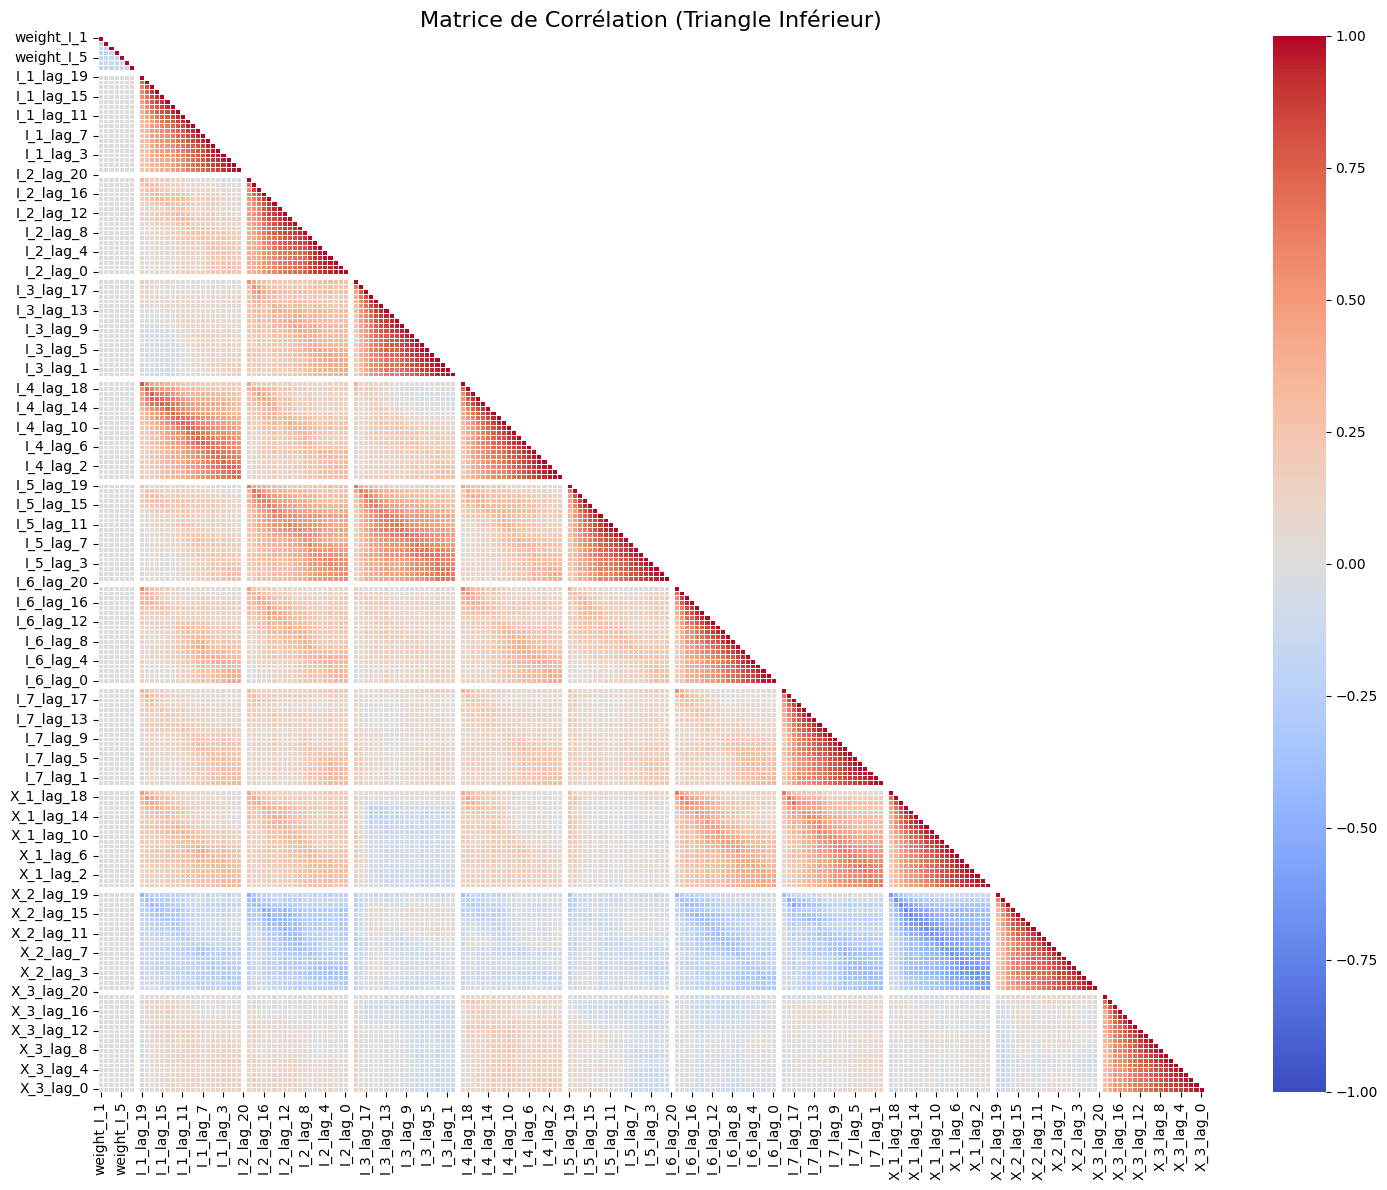

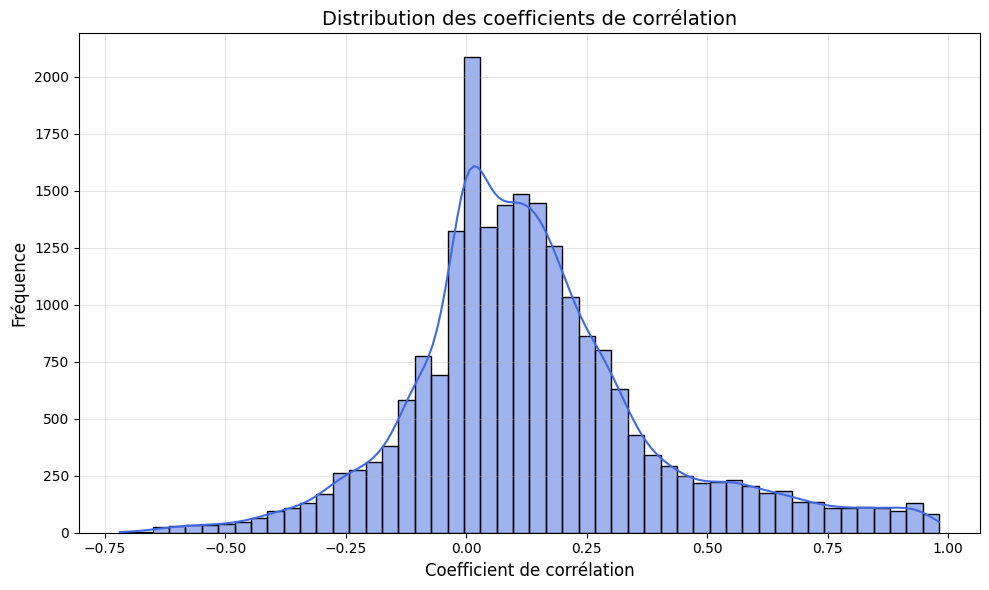

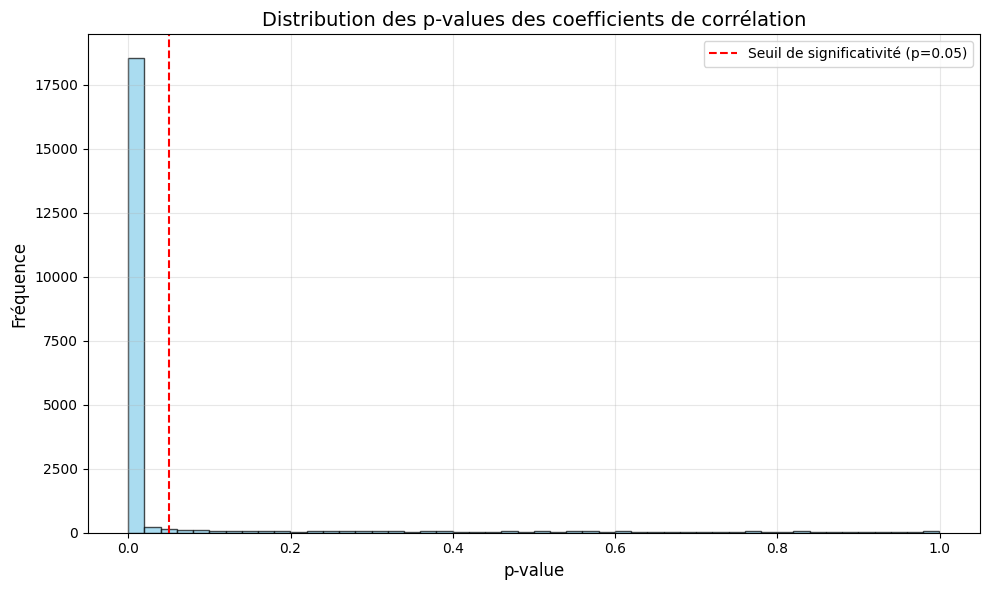

Nombre de corrélations testées : 23436
Nombre de corrélations significatives (p < 0.05) : 18833
Pourcentage de corrélations significatives : 80.36%


In [60]:
corr_matrix, significant_percent = analyze_correlations(
    df=features_clean,
    alpha=0.05
)

De ces graphiques, nous pouvons faire deux principales remarques :
- d'un côté, les séries temporelles des valeurs des stratégies ne semblent pas fortement corrélées entre elles, ni avec les poids (zones bleuâtres/grises sur la matrice de corrélation), ni avec les instruments financiers. Cela est positif, puisque cela suggère ces variables n'expliquent pas les mêmes éléments.
- d'un autre côté, de fortes corrélations positives existent au sein des séries temporelles. Cela reflète très probablement la présence d'autocorrélation dans les séries de prix, ce qui est un phénomène connu des marchés. La différenciation permet généralement d'aboutir à des séries stationnaires non autocorrélées. Nous reviendrons plus en détail sur ces points dans la suite.
- on observe que plus de 80% des variables ont une corrélation significative. Un traitement est donc nécessaire pour augmenter le champ d'information expliqué par les variables.

#### 2.3.4. Calcul des rendements

Les features que nous avons à notre disposition contiennent des séries de prix sur 21 jours. Le label final étant le ratio de Sharpe, calculé à partir des rendements des stratégies, nous allons transformer nos séries de prix en rendements (logarithmiques). Cette méthode devrait en outre permettre de **réduire, voire supprimer, l'autocorrélation** dans nos séries temporelles. Les rendements logarithmiques sont utilisés dans le calcul du ratio de Sharpe, ce sont donc ceux que nous utiliserons ici.

In [61]:
def compute_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fonction qui procède au calcul des rendements des stratégies et instruments financiers.

    Inputs :
    ----------
    df : DataFrame contenant les features initiaux

    Outputs :
    ----------
    DataFrame avec les poids, suivis des rendements
    """
    # 7 premières colonnes : poids
    rdt = df.iloc[:, :7].copy()

    # Calcul des rendements
    columns_value_strategies = df.columns[7:]
    for i in range(len(columns_value_strategies) - 1):
        current_prices = columns_value_strategies[i]
        next_prices = columns_value_strategies[i + 1]
        col_names = f"rendement_{df.columns[i+8]}"  # cela permet d'avoir
        # des colonnes nommées "rendement_I_lag_19" pour le rendement le plus ancien (le plus proche = lag_0)
        rdt[col_names] = np.log(df[next_prices] / df[current_prices])

    return rdt

# Dataframe avec poids et rendements
features_rdt = compute_returns(features_clean)
cols_rdt_20 = [col for col in features_rdt.columns if "lag_20" in col]
# On retire les colonnes "lag_20" car elles sont le résultat du calcul ln(X_i_lag_0/ X_j_lag_20)
features_rdt = features_rdt.drop(columns=cols_rdt_20)
display(features_rdt.head(5))

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,rendement_X_3_lag_9,rendement_X_3_lag_8,rendement_X_3_lag_7,rendement_X_3_lag_6,rendement_X_3_lag_5,rendement_X_3_lag_4,rendement_X_3_lag_3,rendement_X_3_lag_2,rendement_X_3_lag_1,rendement_X_3_lag_0
ID,,,,,,,,,,,,,,,,,,,,,
0,0.15,0.00,0.05,0.80,0.00,0.0,0.00,0.000474,0.000111,-0.000109,...,0.003170,0.006595,0.003140,0.007522,0.000000,-0.000991,0.000283,0.000566,0.000848,0.001130
1,0.00,0.00,0.00,0.40,0.25,0.0,0.35,-0.000877,0.000482,0.002222,...,0.006313,0.000273,0.000547,0.001366,-0.003829,-0.002195,-0.002200,-0.000276,0.000276,0.002497
2,0.85,0.00,0.00,0.15,0.00,0.0,0.00,-0.005197,0.007191,0.002078,...,-0.001336,0.002076,-0.002670,0.004741,0.002215,-0.003250,0.000000,-0.006235,-0.003132,0.002238
3,0.00,0.00,0.70,0.05,0.25,0.0,0.00,0.001245,-0.001012,0.002725,...,0.001197,0.001941,0.000149,0.005059,0.001335,0.002664,-0.002368,0.001037,0.002365,-0.003846
4,0.00,0.55,0.05,0.00,0.00,0.0,0.40,0.000000,-0.005940,0.000109,...,0.005515,-0.001835,0.001224,0.004271,-0.001828,0.005777,0.000000,0.003935,0.000905,-0.000604


#### 2.3.5. Feature engineering

Nous cherchons à créer un certain nombre de features afin de capturer des dynamiques sous-jacentes plus complexes, qui nous permettront ensuite d'entraîner notre modèle. En plus des rendements journaliers, nous proposons les features suivants :
- covariances entre les rendements des stratégies, entre les rendements des indicateurs économiques et entre les rendements stratégies et les rendements indicateurs économiques (afin d'identifier d'éventuelles relations structurelles entre variables),
- volatilités des rendements (mesure de risque au dénominateur du ratio de Sharpe),
- ratios de Sharpe hebdomadaires (pour capturer une potentielle autocorrélation dans le ratio de Sharpe);
- skewness et kurtosis des rendements (permet de distinguer des stratégies dont la performance repose sur des événements extrêmes de celles qui performent régulièrement. Par exemple, deux stratégies peuvent avoir le même ratio de Sharpe, mais l'une présente une distribution des rendements leptokurtique asymétrique à gauche et donc avec des drawdowns potentiellement larges et réguliers, l'autre symétrique avec faible kurtosis),
- l'indice Herfindahl-Hirschman (HHI) comme mesure de la diversification (permet de voir si le ratio de Sharpe est meilleur lorsque l'AUM est alloué de manière diversifié ou non) :
$$
HHI = \sum_{i=1}^N \omega_i^2, \quad 0 < HHI \leq 1 \\
\begin{cases}
HHI = 1 : \text{ portefeuille totalement concentré} \\
HHI = \frac{1}{N} : \text{ portefeuille équipondéré}
\end{cases}
$$

In [62]:
def feature_engineering(df: pd.DataFrame, weights: Optional[pd.DataFrame]=None,
                        nb_strat: int=7, nb_indic: int=3, nb_days: int=20) -> pd.DataFrame:
    """
    Fonction qui calcule toutes les features :
    - Covariances entre stratégies, indicateurs, et entre les stratégies et les indicateurs
    - Volatilités des stratégies et indicateurs
    - Skewness et kurtosis
    - Ratio de Sharpe personnalisé (si weights est fourni)
    - HHI

    Inputs :
    -----------
        df: DataFrame contenant les rendements
        weights : DataFrame ou array contenant les poids (optionnel)
        nb_strat: Nombre de stratégies (7 par défaut)
        nb_indic: Nombre d'indicateurs (3 par défaut)
        nb_days: Nombre de jours de rendements (20 par défaut)

    Output :
    -----------
        DataFrame contenant toutes les features calculées pour chaque observation.
    """
    nb_rows = df.shape[0]

    # Création de paires et de noms de colonnes
    # On récupère les nb_strat * nb_days premières colonnes pour les rendements des stratégies,
    # et le reste pour les rendements des indicateurs
    strat_cols = df.columns[:nb_strat * nb_days].tolist()
    indic_cols = df.columns[nb_strat * nb_days:(nb_strat + nb_indic) * nb_days].tolist()

    # 1. Définition des colonnes pour les covariances
    strat_pairs = list(combinations(range(1, nb_strat+1), 2))
    strat_strat_cols = [f'cov_I_{i}_I_{j}' for i, j in strat_pairs]

    indicator_pairs = list(combinations(range(1, nb_indic+1), 2))
    indic_indic_columns = [f'cov_X_{i}_X_{j}' for i, j in indicator_pairs]

    strat_indic_pairs = [(i, j) for i in range(1, nb_strat+1) for j in range(1, nb_indic+1)]
    strat_indic_columns = [f'cov_I_{i}_X_{j}' for i, j in strat_indic_pairs]

    # 2. Définition des colonnes pour les volatilités
    vol_columns = [f'vol_I_{s}' for s in range(1, nb_strat+1)] + [f'vol_X_{i}' for i in range(1, nb_indic+1)]

    # 3. Définition des colonnes pour le skewness et kurtosis
    skew_columns = [f'skew_I_{s}' for s in range(1, nb_strat+1)] + [f'skew_X_{i}' for i in range(1, nb_indic+1)]
    kurt_columns = [f'kurt_I_{s}' for s in range(1, nb_strat+1)] + [f'kurt_X_{i}' for i in range(1, nb_indic+1)]

    # 4. Colonnes pour le ratio de Sharpe et HHI (si weights fourni)
    nb_weeks = nb_days // 5
    sharpe_columns = [f'sharpe_week_{w+1}' for w in range(nb_weeks)] if weights is not None else []
    hhi_column = ['HHI'] if weights is not None else []

    # Combinaison de toutes les colonnes pour le tableau final
    all_columns = strat_strat_cols + indic_indic_columns + strat_indic_columns + \
        vol_columns + skew_columns + kurt_columns + sharpe_columns + hhi_column
    results = pd.DataFrame(np.nan, index=df.index, columns=all_columns, dtype=float)


    # On récupère les indices des colonnes pour chaque stratégie et indicateur
    strat_indices = {}
    indic_indices = {}

    for s in range(1, nb_strat+1):
        strat_cols_s = strat_cols[(s-1)*nb_days:s*nb_days]
        strat_indices[s] = [df.columns.get_loc(col) for col in strat_cols_s]

    for i in range(1, nb_indic+1):
        indic_cols_i = indic_cols[(i-1)*nb_days:i*nb_days]
        indic_indices[i] = [df.columns.get_loc(col) for col in indic_cols_i]


    for row_pos in range(nb_rows):
        idx = df.index[row_pos]              # index initial (à conserver)
        row_values = df.iloc[row_pos].values


        # Extraction des données pour chaque stratégie et indicateur
        strat_data = {}
        indic_data = {}

        for s in range(1, nb_strat+1):
            strat_data[s] = row_values[strat_indices[s]]

        for i in range(1, nb_indic+1):
            indic_data[i] = row_values[indic_indices[i]]

        ########## Calcul des covariances ##########

        for col_idx, (s1, s2) in enumerate(strat_pairs):
            cov = np.cov(strat_data[s1], strat_data[s2])[0, 1]
            results.loc[idx, strat_strat_cols[col_idx]] = cov

        # Entre indicateurs
        for col_idx, (i1, i2) in enumerate(indicator_pairs):
            cov = np.cov(indic_data[i1], indic_data[i2])[0, 1]
            results.loc[idx, indic_indic_columns[col_idx]] = cov

        # Entre stratégies et indicateurs
        for col_idx, (s, i) in enumerate(strat_indic_pairs):
            cov = np.cov(strat_data[s], indic_data[i])[0, 1]
            results.loc[idx, strat_indic_columns[col_idx]] = cov

        ########## Calcul des volatilités ##########
        for s in range(1, nb_strat+1):
            vol = np.std(strat_data[s], ddof=1)
            results.loc[idx, f'vol_I_{s}'] = vol

        for i in range(1, nb_indic+1):
            vol = np.std(indic_data[i], ddof=1)
            results.loc[idx, f'vol_X_{i}'] = vol

        ########## Calcul des skewness et kurtosis ##########
        for s in range(1, nb_strat+1):
            results.loc[idx, f'skew_I_{s}'] = stats.skew(strat_data[s])
            results.loc[idx, f'kurt_I_{s}'] = stats.kurtosis(strat_data[s], fisher=True)

        for i in range(1, nb_indic+1):
            results.loc[idx, f'skew_X_{i}'] = stats.skew(indic_data[i])
            results.loc[idx, f'kurt_X_{i}'] = stats.kurtosis(indic_data[i], fisher=True)

        ########## Calcul du HHI ##########
        if weights is not None:
            # On récupère les poids pour la ligne
            if isinstance(weights, pd.DataFrame):
                w = weights.loc[idx].values
            else:
                w = weights[row_pos]

            hhi = np.sum(w ** 2)    
            results.loc[idx, 'HHI'] = hhi

        ########## Calcul des ratios de Sharpe ##########
        if weights is not None:
            # Récupérer les poids pour cette ligne
            if isinstance(weights, pd.DataFrame):
                w = weights.loc[idx].values
            else:
                w = weights[row_pos]

            # Calcul pour chaque semaine
            for week in range(nb_weeks):
                # Indices pour la semaine
                start_idx = week * 5
                end_idx = start_idx + 5

                # Calcul du numérateur
                weekly_returns = np.zeros(nb_strat)
                # On calcule la somme des rendements pour chaque stratégie
                for s in range(1, nb_strat+1):
                    weekly_returns[s-1] = np.sum(strat_data[s][start_idx:end_idx])
                # Somme pondérée des rendements hebdomadaires + annualisation
                weighted_return = np.sum(w * weekly_returns) * (252 / 5)

                # Calcul du dénominateur
                # Matrice de covariance
                # Remarque : le calcul "manuel" est nécessaire car on considère les rendements d'un seul échantillon
                cov_matrix = np.zeros((nb_strat, nb_strat))

                for i in range(1, nb_strat+1):
                    for j in range(1, nb_strat+1):
                        # On récupère tous les rendements pour les stratégies i et j
                        returns_i = strat_data[i]
                        returns_j = strat_data[j]

                        # Moyennes des rendements
                        mean_i = np.mean(returns_i)
                        mean_j = np.mean(returns_j)

                        # Covariance
                        dev_i = returns_i - mean_i
                        dev_j = returns_j - mean_j
                        cov_ij = np.sum(dev_i * dev_j) / (len(returns_i) - 1)

                        cov_matrix[i-1, j-1] = cov_ij

                # Calcul de la variance du portefeuille pondéré
                portfolio_variance = np.dot(w.T, np.dot(cov_matrix, w))

                # Volatilité annualisée
                portfolio_volatility = np.sqrt(252 * portfolio_variance)

                # Seuil minimum de 0.005
                denominator = max(portfolio_volatility, 0.005)

                # Ratio de Sharpe
                sharpe_ratio = weighted_return / denominator
                results.loc[idx, f'sharpe_week_{week+1}'] = sharpe_ratio

    return results

def process_features(features_rdt: pd.DataFrame) -> pd.DataFrame:
    """
    Fonction qui permet de concaténer tous nos features :
        - ceux créés via la fonction ci-dessus,
        - les poids,
        - les rendements journaliers.

    Input :
        features_rdt : DataFrame contenant toutes les données

    Output :
        DataFrame contenant toutes les features
    """
    # Colonnes par type
    cols_strategies = [col for col in features_rdt.columns if "rendement_I" in col]
    cols_indicators = [col for col in features_rdt.columns if "X" in col]


    features_data = features_rdt[cols_strategies+cols_indicators]
    weight_columns = features_rdt.iloc[:,:7]

    # On calcule toutes les features
    new_features = feature_engineering(features_data, weight_columns)
    # On ajoute les rendements bruts aux features
    rendements_df = features_data
    # On ajoute les poids et les rendements
    new_features = pd.concat([weight_columns, rendements_df, new_features], axis=1)
    new_features = new_features.apply(pd.to_numeric, errors='coerce')
    # On vérifie les dimensions
    print(f"features_rdt: {features_rdt.shape}")
    print(f"new_features: {new_features.shape}")

    return new_features

In [63]:
features_total = process_features(features_rdt)
display(features_total.head(5))

features_rdt: (9933, 207)
new_features: (9933, 287)


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,kurt_I_6,kurt_I_7,kurt_X_1,kurt_X_2,kurt_X_3,sharpe_week_1,sharpe_week_2,sharpe_week_3,sharpe_week_4,HHI
ID,,,,,,,,,,,,,,,,,,,,,
0,0.15,0.00,0.05,0.80,0.00,0.0,0.00,0.000474,0.000111,-0.000109,...,3.811761,3.535207,-0.484368,-1.019894,1.764071,-1.925208,7.977686,-2.132942,-8.615628,0.665
1,0.00,0.00,0.00,0.40,0.25,0.0,0.35,-0.000877,0.000482,0.002222,...,6.990684,-0.476448,-0.476448,1.147579,-0.128676,6.285693,6.709467,0.803147,17.656251,0.345
2,0.85,0.00,0.00,0.15,0.00,0.0,0.00,-0.005197,0.007191,0.002078,...,2.673641,-0.034851,-0.034851,-0.130658,-0.902351,7.726733,-1.166057,9.987583,5.182329,0.745
3,0.00,0.00,0.70,0.05,0.25,0.0,0.00,0.001245,-0.001012,0.002725,...,3.672120,0.517233,0.517233,-0.909922,-0.772276,5.733866,6.685264,-7.017447,-1.944735,0.555
4,0.00,0.55,0.05,0.00,0.00,0.0,0.40,0.000000,-0.005940,0.000109,...,3.000790,-0.088999,-0.117941,-0.640775,0.913934,3.883034,-0.671889,3.744763,-4.886388,0.465


Après ces calculs, on constate que certaines colonnes affichent des valeurs vides (NaN). Plus précisément, on identifie qu'elles sont présentes dans les skewness et kurtosis des rendements calculés en $t-4$ et $t-6$. On décide de supprimer ces colonnes. En effet, le nombre conséquent de valeurs vides dans ces 4 colonnes rend difficile la justification d'un remplacement par une valeur. De plus, le nombre important de données à notre disposition devrait rendre marginal l'effet de ces suppressions.

In [64]:
features_total = features_total.drop(["skew_I_6", "kurt_I_6", "skew_I_4", "kurt_I_4"], axis = 1)

In [65]:
pd.options.display.max_rows = None
print(f"Le fichier de données contient {features_total.isna().sum().sum()} données manquantes.")

Le fichier de données contient 0 données manquantes.


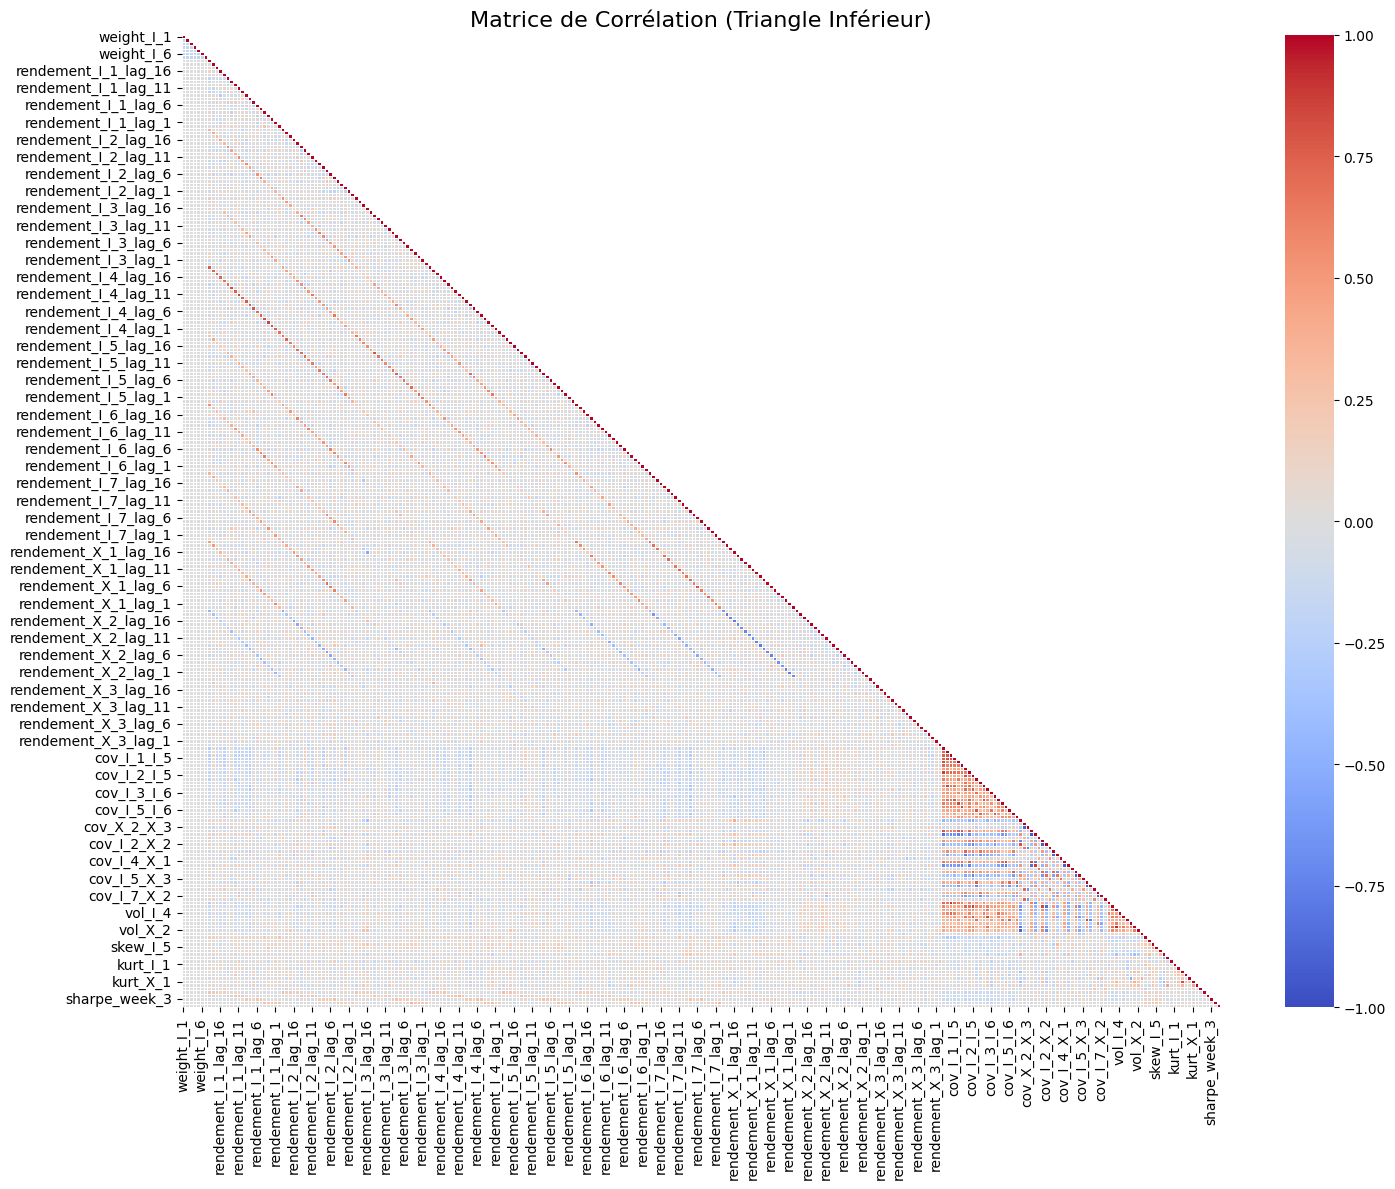

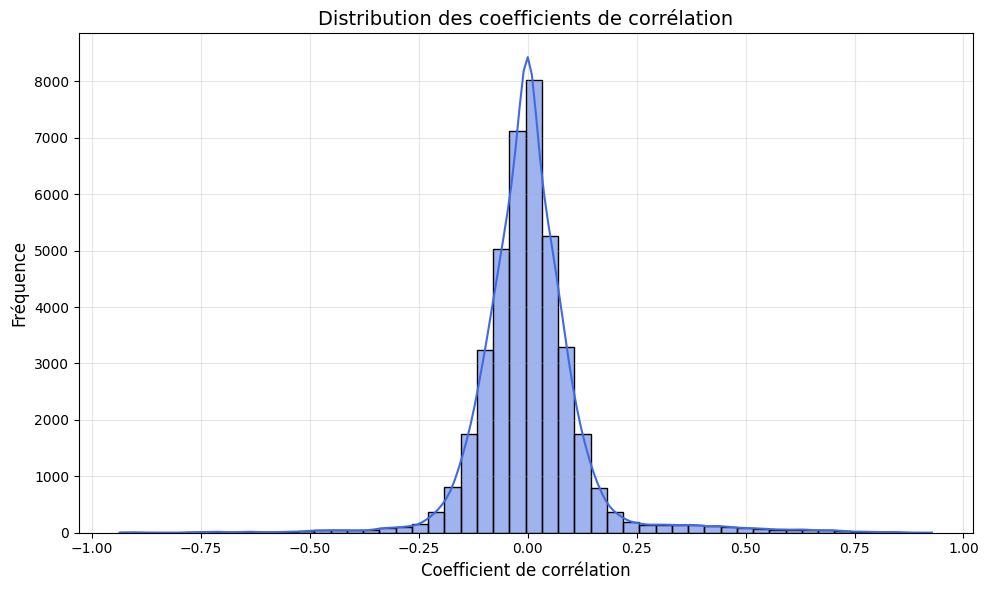

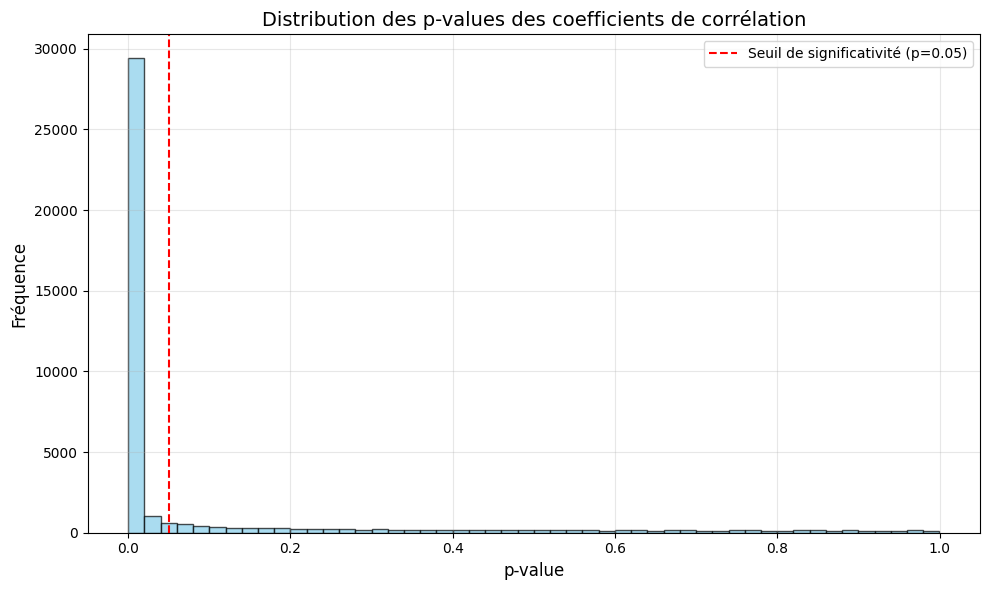

Nombre de corrélations testées : 39903
Nombre de corrélations significatives (p < 0.05) : 30751
Pourcentage de corrélations significatives : 77.06%


In [66]:
new_corr_matrix, new_significant_percent = analyze_correlations(features_total)

#### 2.3.6. Corrélation entre les features et la cible

In [67]:
print(labels_clean.info())
print(features_total.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9933 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  9933 non-null   float64
dtypes: float64(1)
memory usage: 155.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 9933 entries, 0 to 9999
Columns: 283 entries, weight_I_1 to HHI
dtypes: float64(283)
memory usage: 21.8 MB
None


In [68]:
merge_for_corr = features_total.join(labels_clean)
print(merge_for_corr.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9933 entries, 0 to 9999
Columns: 284 entries, weight_I_1 to Target
dtypes: float64(284)
memory usage: 21.9 MB
None


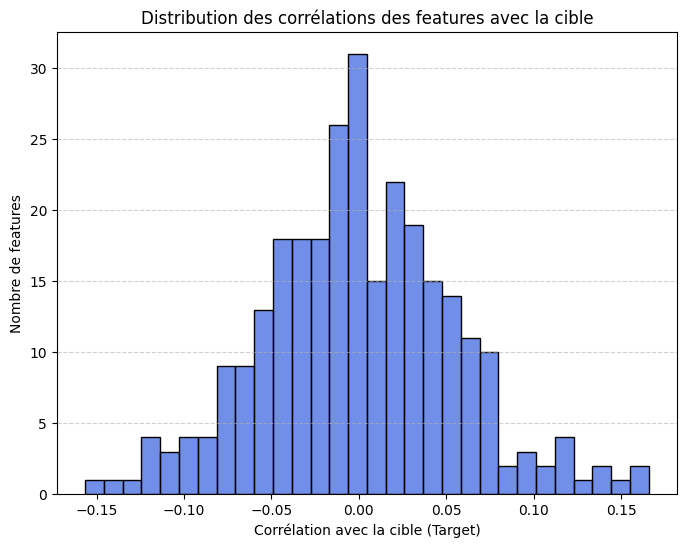

In [69]:
corr_label = merge_for_corr.corr()
corr_target = corr_label["Target"].drop("Target")
n = len(corr_label)
pvalues = corr_target.apply(lambda r: pearson_pvalue(r, n))

# Histogramme des corrélations
plt.figure(figsize=(8, 6))
sns.histplot(corr_target, bins=30, kde=False, color="royalblue")
plt.xlabel("Corrélation avec la cible (Target)")
plt.ylabel("Nombre de features")
plt.title("Distribution des corrélations des features avec la cible")
plt.grid(axis="y", linestyle="--", alpha=0.6)

Le graphique met en évidence que les corrélations marginales entre les variables explicatives et le ratio de Sharpe futur sont globalement faibles et centrées autour de zéro. Ce résultat est cohérent avec la nature du problème étudié et ne suggère pas la présence d’erreurs dans la construction des données ou dans la méthodologie employée.

En effet, le ratio de Sharpe est une mesure de performance complexe et non linéaire, qui dépend conjointement des rendements futurs, des volatilités, des covariances entre stratégies et des pondérations du portefeuille. Il est donc peu probable qu’une variable prise isolément présente une corrélation linéaire élevée avec cette cible, en particulier sur un horizon très court de cinq jours et dans un contexte de marchés de cryptomonnaies fortement volatils.

La faiblesse des corrélations marginales indique ainsi que le signal prédictif potentiel, s’il existe, réside principalement dans des interactions entre variables plutôt que dans des effets linéaires simples. Cela implique que la prédiction du ratio de Sharpe est intrinsèquement difficile, mais pas impossible, et justifie le recours à des modèles non linéaires capables de capter des dépendances complexes.

La problématique proposée par Napoleon est ambitieuse car prédire un ratio de Sharpe hebdomadaire est une tache complexe. Il y a plusieurs raisons à cela, premièrement, les rendements financiers sont très peu autocorrélés contrairement à la volatilités ou aux prix. C'est le cas dans nos données, les rendements des stratégies ne présentent pas d'autocorrélations, en revanche aux mêmes dates les rendements de différentes stratégies peuvent être corrélées. En l'absence d'autocorrélation, la prédiction de rendement et donc du ratio de Sharpe (qui necessite une prédiction sur cinq jours) est difficile. Les rendements étant presque imprévisibles et la volatilité étant très instable, le ratio de Sharpe futur hebomadaire est très bruité et surement peu lié aux informations passées. Ce bruit est amplifié par l'annualisation. Le graphique ci-dessus montre des corrélations entre notre cible et nos features très faibles et confirment que le signal est faible. 

### 2.4 Séparation du dataset

La division des données d’entraînement en jeux d’apprentissage et de validation est indispensable afin d’évaluer la capacité de généralisation du modèle. Dans notre cas, cette séparation requiert une attention particulière. En effet, notre dataset est construit à partir de fenêtres temporelles de 21 jours, chaque trajectoire de marché étant réutilisée jusqu’à 50 fois avec différentes combinaisons de poids appliquées aux stratégies. Deux observations distinctes peuvent ainsi correspondre à la même série temporelle sous-jacente, différant uniquement par leur pondération.

Afin d’éviter tout data leakage, il est donc impératif que deux observations partageant la même trajectoire de prix ne puissent jamais être réparties entre des ensembles d’apprentissage et de validation (ou de test). Autrement dit, toutes les “prises de vue” d’un même scénario de marché doivent être traitées comme une unité indivisible.

Pour répondre à cette contrainte, nous définissons des groupes d’observations à partir de la valeur finale d’une stratégie donnée (arbitrairement la deuxième, I_2_lag_0). Comme chaque stratégie est normalisée à 100 au début de chaque fenêtre, deux observations présentant exactement la même valeur finale pour cette stratégie correspondent nécessairement à la même trajectoire de 21 jours, indépendamment des poids appliqués. Ces observations sont donc regroupées sous un identifiant de groupe unique.

Dans un premier temps, nous procédons à une séparation explicite d’un jeu de test. Cette séparation est réalisée à l’aide de GroupShuffleSplit, qui sélectionne aléatoirement une fraction des groupes (20 % dans notre cas) pour constituer le jeu de test, tout en garantissant qu’aucun groupe n’est partagé entre les ensembles train/validation et test. Cette étape permet d’obtenir une évaluation finale totalement indépendante, réalisée sur des séries temporelles jamais observées durant la phase de sélection du modèle.

In [ ]:
# --- Sécurité: travail sur des copies
fc = features_clean.copy()

# -------------------------------------------------------------------
# 1) Construction de groupes robustes : hachage des trajectoires COMPLÈTES de 21 jours
#    Cela garantit : même trajectoire -> même groupe
# -------------------------------------------------------------------
ts_cols = [c for c in fc.columns if "_lag_" in c]
if len(ts_cols) == 0:
    raise ValueError("No *_lag_* columns found in features_clean. Adapt ts_cols selection.")

fc["Group"] = pd.util.hash_pandas_object(fc[ts_cols].round(6), index=False).astype("int64")
groups_all = fc["Group"].to_numpy()
idx_all = fc.index.to_numpy()

# -------------------------------------------------------------------
# 2) Split groups: (Train+Val) / Test, puis Train / Val
#    Exemple: 60/20/20 via 0.2 test puis 0.25 sur le reste de val
# -------------------------------------------------------------------
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
trval_pos, test_pos = next(gss1.split(idx_all, groups=groups_all))

idx_trval = idx_all[trval_pos]
idx_test  = idx_all[test_pos]

groups_trval = groups_all[trval_pos]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.20
tr_pos, val_pos = next(gss2.split(idx_trval, groups=groups_trval))

idx_train = idx_trval[tr_pos]
idx_val   = idx_trval[val_pos]

# -------------------------------------------------------------------
# 3) Build final datasets
# -------------------------------------------------------------------
# (mêmes indices à travers les frames)
X_train = features_total.loc[idx_train].copy()
X_val   = features_total.loc[idx_val].copy()
X_test  = features_total.loc[idx_test].copy()

Y_train = labels_clean.loc[idx_train].copy()
Y_val   = labels_clean.loc[idx_val].copy()
Y_test  = labels_clean.loc[idx_test].copy()

# Keep group arrays if you need them later (e.g. for diagnostics)
groups_train = fc.loc[idx_train, "Group"].to_numpy()
groups_val   = fc.loc[idx_val, "Group"].to_numpy()
groups_test  = fc.loc[idx_test, "Group"].to_numpy()

# -------------------------------------------------------------------
# 4)  leakage checks (les groupes doivent être disjoints)
# -------------------------------------------------------------------
assert set(groups_train).isdisjoint(set(groups_val)),  "Leakage: train/val share groups!"
assert set(groups_train).isdisjoint(set(groups_test)), "Leakage: train/test share groups!"
assert set(groups_val).isdisjoint(set(groups_test)),   "Leakage: val/test share groups!"

print("Split sizes:")
print("  Train:", len(X_train), "obs |", len(np.unique(groups_train)), "groups")
print("  Val  :", len(X_val),   "obs |", len(np.unique(groups_val)),   "groups")
print("  Test :", len(X_test),  "obs |", len(np.unique(groups_test)),  "groups")

print("\nTarget summary (mean / median):")
for name, yy in [("Train", Y_train["Target"]), ("Val", Y_val["Target"]), ("Test", Y_test["Target"])]:
    print(f"  {name}: mean={yy.mean():.4f}  median={yy.median():.4f}  std={yy.std():.4f}")


Split sizes:
  Train: 5958 obs | 120 groups
  Val  : 1990 obs | 40 groups
  Test : 1985 obs | 40 groups

Target summary (mean / median):
  Train: mean=1.3927  median=0.9046  std=5.6765
  Val: mean=1.2793  median=1.2283  std=6.0447
  Test: mean=1.0093  median=0.9811  std=5.9430


Nous vérifions manuelement si la séparation a fonctionnée comme nous le souhaitions et que chaque groupe d'observation contenant les mêmes séries temporelles sont bien dans les mêmes set. Si deux observations avec les mêmes séries temporelles (mais poids différents) s'étaient par exemple retrouvées dans le train set pour l'une et dans le test set pour l'autre alors il y aurait eu du data leaking. Pour faire une vérification suplémentaire nous selectionnons un groupe d'observation présentant la même série temporelle (50 observations) dans nos données et vérifions que ce groupe soit présent dans un unique set. Nous montrons les premières vérifications qui consistent à vérifier que les 50 index sont bien dans le même set : 

In [71]:
print((X_test.index == 6).sum()) # dans nos datas 6 est le premier index du groupes de 50 observations 
print((Y_test.index == 6).sum())
print((X_test.index == 109).sum()) 
print((Y_test.index == 109).sum())
print((X_test.index == 435).sum()) 
print((Y_test.index == 435).sum())
print((X_test.index == 921).sum()) 
print((Y_test.index == 921).sum())

# ...

1
1
1
1
1
1
1
1


La train set contient 7948 observations, et le test set en contient 1985. 

Nous suprimons des outliers sur le train set, pour qu'ils n'aient pas trop d'impact sur l'estimation. La prédiction et l'évalutation se feront sur les données d'origines, sans suppression d'outiliers. 

In [ ]:
y = Y_train["Target"]  


Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

k = 2.0  
lower = Q1 - k * IQR
upper = Q3 + k * IQR

mask = (y >= lower) & (y <= upper)   #  Series Boolenne indexé comme X_train/Y_train

print(f"TRAIN obs avant filtrage : {len(Y_train)}")
print(f"TRAIN obs après filtrage : {int(mask.sum())}")
print(f"IQR filter bounds: [{lower:.3f}, {upper:.3f}]")

# Filtre TRAIN seule
X_train = X_train.loc[mask].copy()
Y_train = Y_train.loc[mask].copy()


TRAIN obs avant filtrage : 5958
TRAIN obs après filtrage : 5853
IQR filter bounds: [-14.313, 17.735]


### 2.5 Prétraitement et fonctions utilitaires
Cette section regroupe les fonctions dédiées au prétraitement des données et à l’évaluation des modèles. Elles permettent de construire des pipelines de transformation (standardisation optionnelle) et d’implémenter une validation croisée respectant la structure des groupes. L’ensemble de ces fonctions est conçu pour garantir une évaluation sans data leakage, les opérations de prétraitement étant systématiquement ajustées sur les données d’entraînement de chaque fold.




Une fois le jeu de test isolé, nous appliquons une validation croisée groupée sur les données restantes. Pour cela, nous utilisons la méthode GroupKFold de scikit-learn, qui divise le jeu train/validation en $k$ folds en respectant strictement la structure des groupes. À chaque itération, certains groupes sont utilisés pour l’apprentissage tandis que les groupes restants servent à la validation. Cette procédure garantit qu’une trajectoire de marché donnée ne peut jamais apparaître simultanément dans les ensembles d’apprentissage et de validation, même sous des pondérations différentes.

La performance du modèle est évaluée sur chaque fold de validation, puis moyennée afin d’obtenir une estimation robuste de ses capacités de généralisation. Cette stratégie combinant séparation préalable du jeu de test et validation croisée groupée est essentielle pour prévenir tout data leakage dans un cadre où les observations présentent une forte redondance temporelle.

La fonction evaluate_cv_sklearn évalue un modèle par validation croisée groupée en entraînant l’estimateur sur chaque fold, en mesurant ses performances sur des groupes de données non vus, et en produisant à la fois des scores par fold et des prédictions out-of-fold.

In [74]:
# -------------------------
# Helpers
# -------------------------
def y1d(Y):
    """Y can be DataFrame with 'Target' or a Series/ndarray -> 1d numpy"""
    if isinstance(Y, pd.DataFrame):
        return Y["Target"].to_numpy().ravel()
    if isinstance(Y, pd.Series):
        return Y.to_numpy().ravel()
    return np.asarray(Y).ravel()

# -------------------------
# Core: manual random search on VALIDATION (no CV)
# -------------------------
def tune_on_val(
    base_pipe: Pipeline,
    param_dist: dict,
    X_train, Y_train,
    X_val, Y_val,
    n_iter: int = 40,
    seed: int = 42,
    clip=None,
    verbose: int = 1,
):
    ytr = y1d(Y_train)
    yva = y1d(Y_val)

    best_val = np.inf
    best_params = None
    best_pipe = None

    sampler = ParameterSampler(param_dist, n_iter=n_iter, random_state=seed)

    for i, params in enumerate(sampler, start=1):
        pipe = clone(base_pipe)
        pipe.set_params(**params)
        pipe.fit(X_train, ytr)

        pred_val = pipe.predict(X_val).ravel()
        if clip is not None:
            pred_val = np.clip(pred_val, clip[0], clip[1])

        val_score = mean_absolute_error(yva, pred_val)  # lower is better

        if verbose:
            print(f"[{i:02d}/{n_iter}] VAL={val_score:.4f}  params={params}")

        if val_score < best_val:
            best_val = val_score
            best_params = params
            best_pipe = pipe

    return best_pipe, best_params, best_val

# -------------------------
# Refit on Train+Val and evaluate on Test
# -------------------------
def refit_trainval_and_test(best_params, base_pipe, X_train, Y_train, X_val, Y_val, X_test, Y_test, clip=None):
    ytr = y1d(Y_train)
    yva = y1d(Y_val)
    yte = y1d(Y_test)

    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = np.concatenate([ytr, yva], axis=0)

    final_pipe = clone(base_pipe)
    final_pipe.set_params(**best_params)
    final_pipe.fit(X_trval, y_trval)

    pred_test = final_pipe.predict(X_test).ravel()
    if clip is not None:
        pred_test = np.clip(pred_test, clip[0], clip[1])

    test_score = mean_absolute_error(yte, pred_test)

    print("\n=== FINAL (refit Train+Val) ===")
    print("Best params:", best_params)
    print(f"TEST score: {test_score:.4f}")
    print(f"corr(pred,y): {np.corrcoef(pred_test, yte)[0,1]:.4f}")
    print(f"std(pred)={np.std(pred_test):.4f}  std(y)={np.std(yte):.4f}")

    return final_pipe, test_score, pred_test


## 3. Prédiction

### 3.1 Benchmark

On observe un modèle de référence naïf qui prédit systématiquement la moyenne du label observée sur l’ensemble d’apprentissage, afin de disposer d’un point de comparaison minimal pour l’évaluation des modèles. 

In [75]:
print(Y_train.describe())

            Target
count  5853.000000
mean      1.641645
std       5.122956
min     -14.311096
25%      -1.293142
50%       0.971669
75%       4.940975
max      17.708526


In [76]:
bench_const = float(Y_train.mean())
bench_pred = np.full_like(Y_test.values, bench_const, dtype=float)

bench_score = mean_absolute_error(Y_test.values, bench_pred)

print("Benchmark const (train mean):", bench_const)
print("Benchmark MAE:", bench_score)

Benchmark const (train mean): 1.6416448038594118
Benchmark MAE: 4.452587992456524


In [77]:
print(Y_train.median())
print(Y_train.mean())
print(Y_test.median())
print(Y_test.mean())

Target    0.971669
dtype: float64
Target    1.641645
dtype: float64
Target    0.981095
dtype: float64
Target    1.009333
dtype: float64


### 3.2 Elasticnet

#### Elasticnet - Modèle (1)

In [78]:
pipe_simple = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(random_state=cfg.seed, max_iter=40_000, tol=1e-3))
])

space = {
    "model__alpha": np.logspace(-5, 1, 50),
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

best_val = 1e18
best_params = None
best_pipe = None

for params in ParameterSampler(space, n_iter=cfg.n_iter_fast, random_state=cfg.seed):
    p = clone(pipe_simple)
    p.set_params(**params)
    p.fit(X_train, ytr)
    pv = p.predict(X_val).ravel()
    s = mean_absolute_error(yva, pv)
    if s < best_val:
        best_val = s
        best_params = params
        best_pipe = p

print("Best VAL (simple enet):", best_val, "params:", best_params)

# refit train+val
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva])

final = clone(pipe_simple).set_params(**best_params)
final.fit(X_trval, y_trval)

pt = final.predict(X_test).ravel()
print("TEST mae (simple enet):", mean_absolute_error(yte, pt))

if np.std(pt) < 1e-12:
    corr = 0.0
else:
    corr = np.corrcoef(pt, yte)[0, 1]

std_pred = np.std(pt)
print("corr(pred, y):", corr)
print("std(pred):", std_pred)
print("std(y):", np.std(yte))

Best VAL (simple enet): 4.75464199306422 params: {'model__l1_ratio': 0.5, 'model__alpha': np.float64(0.5963623316594636)}
TEST mae (simple enet): 4.336246844332188
corr(pred, y): 0.22665361357763458
std(pred): 1.4580861359654949
std(y): 5.9414764960521165


#### Elastic Net - Modèle test "agressif"

In [79]:
pipe_simple = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(random_state=cfg.seed, max_iter=40_000, tol=1e-3))
])

space_force = {
    "model__alpha": np.logspace(-5, -1, 30),     
    "model__l1_ratio": [0.3, 0.5, 0.7, 0.9]
}

ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

best_val = 1e18
best_params = None
best_pipe = None

for params in ParameterSampler(space_force, n_iter=cfg.n_iter_fast, random_state=cfg.seed):
    p = clone(pipe_simple)
    p.set_params(**params)
    p.fit(X_train, ytr)
    pv = p.predict(X_val).ravel()
    s = mean_absolute_error(yva, pv)
    if s < best_val:
        best_val = s
        best_params = params
        best_pipe = p

print("Best VAL (simple enet):", best_val, "params:", best_params)

# refit train+val
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva])

final = clone(pipe_simple).set_params(**best_params)
final.fit(X_trval, y_trval)

pt = final.predict(X_test).ravel()
print("TEST mae (simple enet):", mean_absolute_error(yte, pt))


if np.std(pt) < 1e-12:
    corr = 0.0
else:
    corr = np.corrcoef(pt, yte)[0, 1]

std_pred = np.std(pt)
print("corr(pred, y):", corr)
print("std(pred):", std_pred)
print("std(y):", np.std(yte))

Best VAL (simple enet): 5.888162209909319 params: {'model__l1_ratio': 0.9, 'model__alpha': np.float64(0.03856620421163472)}
TEST mae (simple enet): 6.077538484154399
corr(pred, y): 0.03561185733263737
std(pred): 5.498880984425483
std(y): 5.9414764960521165


Un pipeline ElasticNet avec sélection de variables (via SelectFromModel) est optimisé par validation croisée groupée sur les hyperparamètres du sélecteur et du modèle, puis évalué afin d’estimer de manière robuste ses performances et de le comparer à la version sans sélection de variables.

### 3.3 RandomForest 

#### RandomForest - Modèle (2)

In [80]:
# -----------------------
# Pipeline RF (no scaler needed)
# -----------------------
rf = Pipeline([
    ("model", RandomForestRegressor(
        random_state=cfg.seed,
        n_jobs=-1
    ))
])

# -----------------------
# Hyperparameter space (keep it modest)
# -----------------------
rf_space = {
    "model__n_estimators": [500, 800, 1200],
    "model__max_depth": [None, 10, 14],
    "model__min_samples_leaf": [2, 4, 8, 16],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],
}


# -----------------------
# y arrays
# -----------------------
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# -----------------------
# Tune on VALIDATION (fit TRAIN, score VAL)
# -----------------------
best_val = np.inf
best_params = None
best_pipe = None

for i, params in enumerate(
    ParameterSampler(rf_space, n_iter=cfg.n_iter_fast, random_state=cfg.seed),
    start=1
):
    pipe = clone(rf)
    pipe.set_params(**params)
    pipe.fit(X_train, ytr)

    pred_val = pipe.predict(X_val)
    val_score = mean_absolute_error(yva, pred_val)

    print(f"[{i:02d}/{cfg.n_iter_fast}] VAL={val_score:.4f}  params={params}")

    if val_score < best_val:
        best_val = val_score
        best_params = params
        best_pipe = pipe

print("\nRF best on VAL:", best_val)
print("Best params:", best_params)

# -----------------------
# Refit on Train + Val
# -----------------------
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

rf_final = clone(rf)
rf_final.set_params(**best_params)
rf_final.fit(X_trval, y_trval)

# -----------------------
# Evaluate on TEST
# -----------------------
pred_test = rf_final.predict(X_test)
test_score = mean_absolute_error(yte, pred_test)


print("MAE:", test_score)

# -----------------------
# Diagnostics (optional but useful)
# -----------------------
print("corr(pred,y):", np.corrcoef(pred_test, yte)[0,1])
print("std(pred) / std(y):", np.std(pred_test), np.std(yte))


[01/10] VAL=4.4354  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 16, 'model__max_features': 'sqrt', 'model__max_depth': 10}
[02/10] VAL=4.5706  params={'model__n_estimators': 800, 'model__min_samples_split': 20, 'model__min_samples_leaf': 4, 'model__max_features': 0.3, 'model__max_depth': None}
[03/10] VAL=4.5985  params={'model__n_estimators': 800, 'model__min_samples_split': 20, 'model__min_samples_leaf': 2, 'model__max_features': 0.5, 'model__max_depth': 10}
[04/10] VAL=4.5873  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 0.3, 'model__max_depth': 14}
[05/10] VAL=4.4663  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 14}
[06/10] VAL=4.4452  params={'model__n_estimators': 800, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': '

#### RandomForest - Modèle (3)

In [81]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# -----------------------
# Pipeline ExtraTrees (no scaler needed)
# -----------------------
etr = Pipeline([
    ("model", ExtraTreesRegressor(
        random_state=cfg.seed,
        n_jobs=-1,
        bootstrap=False  # True parfois utile, mais on part sur le standard ExtraTrees
    ))
])

# -----------------------
# Hyperparameter space (proche de ta RF, + un param clé: min_impurity_decrease)
# -----------------------
etr_space = {
    "model__n_estimators": [500, 800, 1200],
    "model__max_depth": [None, 10, 14],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],
    # Optionnel (stabilise parfois) :
    # "model__min_impurity_decrease": [0.0, 1e-6, 1e-5],
}

# -----------------------
# y arrays
# -----------------------
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# -----------------------
# Tune on VALIDATION (fit TRAIN, score VAL)
# -----------------------
best_val = np.inf
best_params = None
best_pipe = None

for i, params in enumerate(
    ParameterSampler(etr_space, n_iter=cfg.n_iter_fast, random_state=cfg.seed),
    start=1
):
    pipe = clone(etr)
    pipe.set_params(**params)
    pipe.fit(X_train, ytr)

    pred_val = pipe.predict(X_val)
    val_score = mean_absolute_error(yva, pred_val)

    print(f"[{i:02d}/{cfg.n_iter_fast}] VAL={val_score:.4f}  params={params}")

    if val_score < best_val:
        best_val = val_score
        best_params = params
        best_pipe = pipe

print("\nExtraTrees best on VAL:", best_val)
print("Best params:", best_params)

# -----------------------
# Refit on Train + Val
# -----------------------
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

etr_final = clone(etr)
etr_final.set_params(**best_params)
etr_final.fit(X_trval, y_trval)

# -----------------------
# Evaluate on TEST
# -----------------------
pred_test = etr_final.predict(X_test)
test_score = mean_absolute_error(yte, pred_test)

print("MAE:", test_score)

# -----------------------
# Diagnostics
# -----------------------
corr = np.corrcoef(pred_test, yte)[0, 1] if np.std(pred_test) > 1e-12 else 0.0
print("corr(pred,y):", corr)
print("std(pred) / std(y):", np.std(pred_test), np.std(yte))


[01/10] VAL=4.3867  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 8, 'model__max_features': 'sqrt', 'model__max_depth': 10}
[02/10] VAL=4.4647  params={'model__n_estimators': 800, 'model__min_samples_split': 20, 'model__min_samples_leaf': 2, 'model__max_features': 0.3, 'model__max_depth': None}
[03/10] VAL=4.4713  params={'model__n_estimators': 800, 'model__min_samples_split': 20, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': 10}
[04/10] VAL=4.4732  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 0.3, 'model__max_depth': 14}
[05/10] VAL=4.4116  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 14}
[06/10] VAL=4.4149  params={'model__n_estimators': 800, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 's

### 3.4 XgBoost 

#### XGBoost - Modèle (4)

In [82]:
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

# y
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# ------------------------------------------------------------
# Même logique que ton code :
# - early stopping sur VAL
# - tuning sur VAL (MAE)
# - refit Train+Val
# Modifs demandées :
# 1) objective = Huber (Pseudo-Huber) : reg:pseudohubererror
# 2) on teste plusieurs caps de n_estimators (grandes valeurs) + early stopping
# ------------------------------------------------------------
xgb_space_huber = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.005, 0.01, 0.02, 0.03],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "colsample_bynode": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 5],
    "gamma": [0.0],
    "reg_alpha": [0.0, 1e-3, 1e-2],
    "reg_lambda": [1.0, 2.0, 5.0],
    "n_estimators": [8000],
}

best_val = np.inf
best_params = None
best_n_estimators = None

for i, params in enumerate(
    ParameterSampler(xgb_space_huber, n_iter=cfg.n_iter_fast, random_state=cfg.seed),
    start=1
):
    model = XGBRegressor(
        # random_state=cfg.seed,
        tree_method="hist",
        objective="reg:pseudohubererror",   # <<< HUBER
        n_jobs=-1,
        verbosity=0,
        eval_metric="mae",
        early_stopping_rounds=200,          # un peu plus de patience
        **params
    )

    # Early stopping sur la VAL
    model.fit(
        X_train, ytr,
        eval_set=[(X_val, yva)],
        verbose=False
    )

    # Score de sélection sur la VAL (MAE)
    pred_val = model.predict(X_val).ravel()
    val_score = mean_absolute_error(yva, pred_val)

    best_iter = getattr(model, "best_iteration", None)
    n_best = (best_iter + 1) if best_iter is not None else params["n_estimators"]

    print(f"[{i:02d}/{cfg.n_iter_fast}] VAL={val_score:.4f}  best_iter={best_iter}  n_best={n_best}  params={params}")

    if val_score < best_val:
        best_val = val_score
        best_params = params
        best_n_estimators = int(n_best)

print("\nXGB best on VAL (Huber):", best_val)
print("Best params:", best_params)
print("Best n_estimators (from early stopping):", best_n_estimators)

# ------------------------------------------------------------
# Refit sur Train+Val avec n_estimators fixé au best_iteration+1
# ------------------------------------------------------------
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

xgb_final = XGBRegressor(
    random_state=cfg.seed,
    tree_method="hist",
    objective="reg:pseudohubererror",  # <<< HUBER aussi ici
    n_jobs=-1,
    verbosity=0,
    eval_metric="mae",
    n_estimators=best_n_estimators,
    **{k: v for k, v in best_params.items() if k != "n_estimators"}
)

xgb_final.fit(X_trval, y_trval, verbose=False)

# ------------------------------------------------------------
# Test
# ------------------------------------------------------------
pred_test = xgb_final.predict(X_test).ravel()
test_mae = mean_absolute_error(yte, pred_test)

print("\nXGB TEST (Huber):")
print("MAE:", test_mae)

corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]
print("\nDiagnostics:")
print("corr(pred,y):", corr)
print("std(pred), std(y):", np.std(pred_test), np.std(yte))


[01/10] VAL=4.3752  best_iter=0  n_best=1  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'n_estimators': 8000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0}
[02/10] VAL=4.3597  best_iter=1  n_best=2  params={'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.01, 'n_estimators': 8000, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.0, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6}
[03/10] VAL=4.3679  best_iter=0  n_best=1  params={'subsample': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 0.001, 'n_estimators': 8000, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.02, 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8}
[04/10] VAL=4.3701  best_iter=0  n_best=1  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'n_estimators': 8000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsa

#### XGBoost - Modèle (5)

In [ ]:
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

# y
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

xgb_space_huber = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.005, 0.01, 0.02, 0.03],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "colsample_bynode": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 5],
    "gamma": [0.0],
    "reg_alpha": [0.0, 1e-3, 1e-2],
    "reg_lambda": [1.0, 2.0, 5.0],
    "n_estimators": [8000],
}

best_val = np.inf
best_params = None
best_n_estimators_es = None  # de early stopping

for i, params in enumerate(
    ParameterSampler(xgb_space_huber, n_iter=cfg.n_iter_fast, random_state=cfg.seed),
    start=1
):
    model = XGBRegressor(
        random_state=cfg.seed,
        tree_method="hist",
        objective="reg:pseudohubererror",
        n_jobs=-1,
        verbosity=0,
        eval_metric="mae",
        early_stopping_rounds=200,
        **params
    )

    model.fit(
        X_train, ytr,
        eval_set=[(X_val, yva)],
        verbose=False
    )

    pred_val = model.predict(X_val).ravel()
    val_score = mean_absolute_error(yva, pred_val)

    best_iter = getattr(model, "best_iteration", None)
    n_best = (best_iter + 1) if best_iter is not None else params["n_estimators"]

    print(f"[{i:02d}/{cfg.n_iter_fast}] VAL={val_score:.4f}  best_iter={best_iter}  n_best={n_best}  params={params}")

    if val_score < best_val:
        best_val = val_score
        best_params = params
        best_n_estimators_es = int(n_best)

print("\nXGB best on VAL (Huber):", best_val)
print("Best params:", best_params)
print("Best n_estimators (from early stopping):", best_n_estimators_es)

# ------------------------------------------------------------
# Refit Train+Val en FORÇANT un minimum d’arbres
# ------------------------------------------------------------
n_min_trees = 50  # <<<<<< force le modèle à apprendre "un peu"
best_n_estimators_forced = max(best_n_estimators_es, n_min_trees)

print("Forced n_estimators used for final refit:", best_n_estimators_forced)

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

xgb_final = XGBRegressor(
    random_state=cfg.seed,
    tree_method="hist",
    objective="reg:pseudohubererror",
    n_jobs=-1,
    verbosity=0,
    eval_metric="mae",
    n_estimators=best_n_estimators_forced,
    **{k: v for k, v in best_params.items() if k != "n_estimators"}
)

xgb_final.fit(X_trval, y_trval, verbose=False)

# ------------------------------------------------------------
# Test
# ------------------------------------------------------------
pred_test = xgb_final.predict(X_test).ravel()
test_mae = mean_absolute_error(yte, pred_test)

print("\nXGB TEST (Huber, forced trees):")
print("MAE:", test_mae)

corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]
print("\nDiagnostics:")
print("corr(pred,y):", corr)
print("std(pred), std(y):", np.std(pred_test), np.std(yte))


[01/10] VAL=4.3812  best_iter=0  n_best=1  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'n_estimators': 8000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0}
[02/10] VAL=4.3698  best_iter=0  n_best=1  params={'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.01, 'n_estimators': 8000, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.0, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6}
[03/10] VAL=4.3656  best_iter=2  n_best=3  params={'subsample': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 0.001, 'n_estimators': 8000, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.02, 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8}
[04/10] VAL=4.3681  best_iter=0  n_best=1  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'n_estimators': 8000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsa

### 3.5 MLP (Keras)

#### MLP - Modèle test : trop instable 

In [ ]:
print("=== Tuning MLP (Classic): Adam + standard scaling + modest regularization + early stopping ===")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# -----------------------
# Hyperparameter space (classic, avec de l'espace pour régularisation)
# -----------------------
mlp_space_classic = {
    # small-to-medium MLPs commonly used on tabular data
    "hidden_units": [(64,), (128,), (64, 32)],
    # modest dropout
    "dropout": [0.0, 0.2, 0.4],
    # standard L2 grid (not too aggressive, but can regularize)
    "l2_reg": [0.0, 1e-4, 1e-2, 1e-1],
    # common Adam learning rates
    "learning_rate": [1e-2, 1e-3, 3e-4],
    "batch_size": [64, 128],
    "epochs": [200],  # max epochs; early stopping decides effective epoch
}

def build_mlp(input_dim, hidden_units, dropout, l2_reg, learning_rate):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    for units in hidden_units:
        x = layers.Dense(
            units,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None,
        )(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Classic default optimizer pour les MLP
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss="mae")
    return model

# -----------------------
# y
# -----------------------
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# -----------------------
# SCALE (fit sur TRAIN seulement)
# -----------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

best_val = np.inf
best_params = None
best_epoch = None

# -----------------------
# Boucle de Tuning (fit TRAIN, score VAL)
# -----------------------
for i, params in enumerate(ParameterSampler(mlp_space_classic, n_iter=30, random_state=42), start=1):
    tf.keras.backend.clear_session()

    model = build_mlp(
        input_dim=X_train_s.shape[1],
        hidden_units=params["hidden_units"],
        dropout=params["dropout"],
        l2_reg=params["l2_reg"],
        learning_rate=params["learning_rate"],
    )

    es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,              # classic patience
        restore_best_weights=True,
        verbose=0
    )

    hist = model.fit(
        X_train_s, ytr,
        validation_data=(X_val_s, yva),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[es],
        verbose=0,
        shuffle=True
    )

    pred_val = model.predict(X_val_s, verbose=0).ravel()
    val_mae = mean_absolute_error(yva, pred_val)

    this_best_epoch = int(np.argmin(hist.history["val_loss"]) + 1)
    print(f"[{i:02d}] VAL={val_mae:.4f} best_epoch={this_best_epoch} params={params}")

    if val_mae < best_val:
        best_val = val_mae
        best_params = params
        best_epoch = this_best_epoch

print(f"\nBest VAL (classic MLP): {best_val:.4f}")
print("Best params:", best_params)
print("Best epoch:", best_epoch)

# -----------------------
# Refit Final sur Train+Val
# Refit scaler sur Train+Val (test inchangé)
# Train pour best_epoch
# -----------------------
print("\nRefitting best model on Train+Val...")

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

scaler_final = StandardScaler()
X_trval_s = scaler_final.fit_transform(X_trval)
X_test_s2 = scaler_final.transform(X_test)

tf.keras.backend.clear_session()
model_final = build_mlp(
    input_dim=X_trval_s.shape[1],
    hidden_units=best_params["hidden_units"],
    dropout=best_params["dropout"],
    l2_reg=best_params["l2_reg"],
    learning_rate=best_params["learning_rate"],
)

model_final.fit(
    X_trval_s,
    y_trval,
    epochs=best_epoch,
    batch_size=best_params["batch_size"],
    verbose=0,
    shuffle=True
)

pred_test = model_final.predict(X_test_s2, verbose=0).ravel()
test_mae = mean_absolute_error(yte, pred_test)
corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]

print("\nTEST RESULTS:")
print(f"MAE:  {test_mae:.4f}")
print(f"Corr: {corr:.4f}")
print(f"std : {np.std(pred_test):.4f}")


=== Tuning MLP (Classic): Adam + standard scaling + modest regularization + early stopping ===
[01] VAL=4.5448 best_epoch=10 params={'learning_rate': 0.01, 'l2_reg': 0.1, 'hidden_units': (128,), 'epochs': 200, 'dropout': 0.4, 'batch_size': 128}
[02] VAL=4.4939 best_epoch=80 params={'learning_rate': 0.01, 'l2_reg': 0.1, 'hidden_units': (64, 32), 'epochs': 200, 'dropout': 0.4, 'batch_size': 128}
[03] VAL=4.9387 best_epoch=4 params={'learning_rate': 0.01, 'l2_reg': 0.01, 'hidden_units': (64, 32), 'epochs': 200, 'dropout': 0.0, 'batch_size': 128}
[04] VAL=4.5486 best_epoch=21 params={'learning_rate': 0.01, 'l2_reg': 0.1, 'hidden_units': (64, 32), 'epochs': 200, 'dropout': 0.2, 'batch_size': 128}
[05] VAL=4.9824 best_epoch=2 params={'learning_rate': 0.01, 'l2_reg': 0.0001, 'hidden_units': (128,), 'epochs': 200, 'dropout': 0.0, 'batch_size': 64}
[06] VAL=4.9745 best_epoch=2 params={'learning_rate': 0.01, 'l2_reg': 0.0001, 'hidden_units': (64,), 'epochs': 200, 'dropout': 0.0, 'batch_size': 12

#### MLP - Modèle test numéro 2 avec taux de dropout et régularisation plus faible : un peu instable

In [ ]:
print("=== Tuning MLP (Stability-focused): low/no dropout + Adam + grad clipping + higher patience ===")

from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# -----------------------
# Espace: priorise la stabilité (dropout + petit, L2 + fin, LR + petit))
# -----------------------

mlp_space_stable = {
    "hidden_units": [(16,), (32,), (32, 16)],          # smaller nets -> less variance
    "dropout": [0.0, 0.1],                             # low/no dropout
    "l2_reg": [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],          # finer + often more stable than 0.05/0.1
    "learning_rate": [1e-3, 5e-4, 2e-4, 1e-4],         # smaller LR for stability
    "batch_size": [64, 128],
    "epochs": [250],                                   # allow longer, early stopping decides
}

def build_mlp(input_dim, hidden_units, dropout, l2_reg, learning_rate):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    for units in hidden_units:
        x = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.Activation("relu")(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Adam + gradient clipping (réduit les sauts run-to-run)
    opt = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=opt, loss="mae")
    return model

# -----------------------
# y
# -----------------------
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# -----------------------
# SCALE (fit sur TRAIN seulement)
# -----------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

best_val = np.inf
best_params = None
best_epoch = None

# -----------------------
#  Boucle de Tunin(fit TRAIN, score VAL)
# -----------------------
for i, params in enumerate(ParameterSampler(mlp_space_stable, n_iter=30, random_state=42), start=1):
    tf.keras.backend.clear_session()

    model = build_mlp(
        X_train_s.shape[1],
        params["hidden_units"],
        params["dropout"],
        params["l2_reg"],
        params["learning_rate"],
    )

    #  Plus patient => moins sensitif au sauts de bruit dans val_loss
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True,
        verbose=0
    )

    hist = model.fit(
        X_train_s, ytr,
        validation_data=(X_val_s, yva),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[es],
        verbose=0,
        shuffle=True   
    )

    pred_val = model.predict(X_val_s, verbose=0).ravel()
    val_mae = mean_absolute_error(yva, pred_val)

    this_best_epoch = int(np.argmin(hist.history["val_loss"]) + 1)

    print(f"[{i:02d}] VAL={val_mae:.4f} best_epoch={this_best_epoch} params={params}")

    if val_mae < best_val:
        best_val = val_mae
        best_params = params
        best_epoch = this_best_epoch

print(f"\nBest VAL (stable MLP): {best_val:.4f}")
print("Best params:", best_params)
print("Best epoch:", best_epoch)

# -----------------------
# Refit Final sur Train+Val (pas de validation_split)
# Refit scaler sur Train+Val (test inchangé)
# Train pour best_epoch
# -----------------------
print("\nRefitting best model on Train+Val...")

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

scaler_final = StandardScaler()
X_trval_s = scaler_final.fit_transform(X_trval)
X_test_s2 = scaler_final.transform(X_test)

tf.keras.backend.clear_session()
model_final = build_mlp(
    X_trval_s.shape[1],
    hidden_units=best_params["hidden_units"],
    dropout=best_params["dropout"],
    l2_reg=best_params["l2_reg"],
    learning_rate=best_params["learning_rate"],
)

model_final.fit(
    X_trval_s,
    y_trval,
    epochs=best_epoch,
    batch_size=best_params["batch_size"],
    verbose=0,
    shuffle=True
)

pred_test = model_final.predict(X_test_s2, verbose=0).ravel()
test_mae = mean_absolute_error(yte, pred_test)
corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]

print("\nTEST RESULTS:")
print(f"MAE:  {test_mae:.4f}")
print(f"Corr: {corr:.4f}")
print(f"std : {np.std(pred_test):.4f}")


=== Tuning MLP (Stability-focused): low/no dropout + Adam + grad clipping + higher patience ===
[01] VAL=4.7168 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.0005, 'hidden_units': (32,), 'epochs': 250, 'dropout': 0.0, 'batch_size': 64}
[02] VAL=4.6085 best_epoch=1 params={'learning_rate': 0.0002, 'l2_reg': 0.0005, 'hidden_units': (16,), 'epochs': 250, 'dropout': 0.0, 'batch_size': 64}
[03] VAL=4.7769 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.005, 'hidden_units': (32,), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[04] VAL=4.5781 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.001, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[05] VAL=4.5549 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.0005, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[06] VAL=4.6459 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.005, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.0, 'batch_

#### MLP - Modèle test numéro 3 avec taux de dropout et régularisation plus faible et un nombre d'"epoch" minimal de 10

In [ ]:
print("=== Tuning MLP (Stability-focused): low/no dropout + Adam + grad clipping + higher patience ===")

from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# -----------------------
# Espace: priorise la stabilité (dropout + petit, L2 + fin, LR + petit))
# -----------------------
mlp_space_stable = {
    "hidden_units": [(16,), (32,), (32, 16)],
    "dropout": [0.0, 0.1],
    "l2_reg": [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    "learning_rate": [1e-3, 5e-4, 2e-4, 1e-4],
    "batch_size": [64, 128],
    "epochs": [250],
}

def build_mlp(input_dim, hidden_units, dropout, l2_reg, learning_rate):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    for units in hidden_units:
        x = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.Activation("relu")(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    opt = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=opt, loss="mae")
    return model

# -----------------------
# y
# -----------------------
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# -----------------------
# SCALE (fit sur TRAIN seulement)
# -----------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

best_val = np.inf
best_params = None
best_epoch = None

# -----------------------
# Boucle de Tuning (fit TRAIN, score VAL)
# -----------------------
for i, params in enumerate(ParameterSampler(mlp_space_stable, n_iter=30, random_state=42), start=1):
    tf.keras.backend.clear_session()

    model = build_mlp(
        X_train_s.shape[1],
        params["hidden_units"],
        params["dropout"],
        params["l2_reg"],
        params["learning_rate"],
    )

    es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True,
        verbose=0
    )

    hist = model.fit(
        X_train_s, ytr,
        validation_data=(X_val_s, yva),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[es],
        verbose=0,
        shuffle=True
    )

    pred_val = model.predict(X_val_s, verbose=0).ravel()
    val_mae = mean_absolute_error(yva, pred_val)

    this_best_epoch = int(np.argmin(hist.history["val_loss"]) + 1)

    print(f"[{i:02d}] VAL={val_mae:.4f} best_epoch={this_best_epoch} params={params}")

    if val_mae < best_val:
        best_val = val_mae
        best_params = params
        best_epoch = this_best_epoch

print(f"\nBest VAL (stable MLP): {best_val:.4f}")
print("Best params:", best_params)
print("Best epoch (val):", best_epoch)

# -----------------------
# Refit Final sur Train+Val
# avec epoch floor = 10
# -----------------------
print("\nRefitting best model on Train+Val (epoch floor = 10)...")

final_epochs = max(best_epoch, 10)
print("Final epochs used:", final_epochs)

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

scaler_final = StandardScaler()
X_trval_s = scaler_final.fit_transform(X_trval)
X_test_s2 = scaler_final.transform(X_test)

tf.keras.backend.clear_session()
model_final = build_mlp(
    X_trval_s.shape[1],
    hidden_units=best_params["hidden_units"],
    dropout=best_params["dropout"],
    l2_reg=best_params["l2_reg"],
    learning_rate=best_params["learning_rate"],
)

model_final.fit(
    X_trval_s,
    y_trval,
    epochs=final_epochs,
    batch_size=best_params["batch_size"],
    verbose=0,
    shuffle=True
)

pred_test = model_final.predict(X_test_s2, verbose=0).ravel()
test_mae = mean_absolute_error(yte, pred_test)
corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]

print("\nTEST RESULTS:")
print(f"MAE:  {test_mae:.4f}")
print(f"Corr: {corr:.4f}")
print(f"std : {np.std(pred_test):.4f}")


=== Tuning MLP (Stability-focused): low/no dropout + Adam + grad clipping + higher patience ===
[01] VAL=4.8997 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.0005, 'hidden_units': (32,), 'epochs': 250, 'dropout': 0.0, 'batch_size': 64}
[02] VAL=4.7066 best_epoch=3 params={'learning_rate': 0.0002, 'l2_reg': 0.0005, 'hidden_units': (16,), 'epochs': 250, 'dropout': 0.0, 'batch_size': 64}
[03] VAL=4.5115 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.005, 'hidden_units': (32,), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[04] VAL=4.5333 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.001, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[05] VAL=4.7376 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.0005, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[06] VAL=4.7178 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.005, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.0, 'batch_

#### MLP - 5 appels du Modèle test numéro 2 

In [87]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterSampler

results = []

seeds = [0, 1, 2, 3, 4]

for seed in seeds:
    print(f"\n===== SEED {seed} =====")
    tf.keras.utils.set_random_seed(seed)
    tf.keras.backend.clear_session()

    # -----------------------
    # SCALE (fit on TRAIN only)
    # -----------------------
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    ytr = Y_train["Target"].to_numpy().ravel()
    yva = Y_val["Target"].to_numpy().ravel()
    yte = Y_test["Target"].to_numpy().ravel()

    best_val = np.inf
    best_params = None
    best_epoch = None

    for params in ParameterSampler(mlp_space_stable, n_iter=30, random_state=seed):
        tf.keras.backend.clear_session()

        model = build_mlp(
            X_train_s.shape[1],
            params["hidden_units"],
            params["dropout"],
            params["l2_reg"],
            params["learning_rate"],
        )

        es = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=30,
            restore_best_weights=True,
            verbose=0
        )

        hist = model.fit(
            X_train_s, ytr,
            validation_data=(X_val_s, yva),
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            callbacks=[es],
            verbose=0,
            shuffle=True
        )

        pred_val = model.predict(X_val_s, verbose=0).ravel()
        val_mae = mean_absolute_error(yva, pred_val)

        epoch_best = int(np.argmin(hist.history["val_loss"]) + 1)

        if val_mae < best_val:
            best_val = val_mae
            best_params = params
            best_epoch = epoch_best

    # -----------------------
    # Refit Train+Val
    # -----------------------
    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = np.concatenate([ytr, yva], axis=0)

    scaler_final = StandardScaler()
    X_trval_s = scaler_final.fit_transform(X_trval)
    X_test_s2 = scaler_final.transform(X_test)

    tf.keras.backend.clear_session()
    model_final = build_mlp(
        X_trval_s.shape[1],
        hidden_units=best_params["hidden_units"],
        dropout=best_params["dropout"],
        l2_reg=best_params["l2_reg"],
        learning_rate=best_params["learning_rate"],
    )

    model_final.fit(
        X_trval_s,
        y_trval,
        epochs=best_epoch,
        batch_size=best_params["batch_size"],
        verbose=0,
        shuffle=True
    )

    pred_test = model_final.predict(X_test_s2, verbose=0).ravel()

    mae = mean_absolute_error(yte, pred_test)
    corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]
    std_pred = np.std(pred_test)

    results.append({
        "seed": seed,
        "MAE": mae,
        "Corr": corr,
        "Std_pred": std_pred,
        "dropout": best_params["dropout"],
        "l2_reg": best_params["l2_reg"],
        "best_epoch": best_epoch,
    })

# -----------------------
# Results table
# -----------------------
results_df = pd.DataFrame(results)
print("\n=== RESULTS (5 seeds) ===")
print(results_df)

print("\n=== MEAN ± STD ===")
print(results_df[["MAE", "Corr", "Std_pred"]].agg(["mean", "std"]))



===== SEED 0 =====

===== SEED 1 =====

===== SEED 2 =====

===== SEED 3 =====

===== SEED 4 =====

=== RESULTS (5 seeds) ===
   seed       MAE      Corr  Std_pred  dropout  l2_reg  best_epoch
0     0  4.559555  0.226510  0.683766      0.1  0.0050           1
1     1  4.452582  0.081430  0.731359      0.1  0.0100           2
2     2  4.531468 -0.044347  0.969937      0.1  0.0001           2
3     3  4.414156  0.081302  0.913251      0.1  0.0001           1
4     4  4.425329  0.110421  0.990440      0.0  0.0001           1

=== MEAN ± STD ===
           MAE      Corr  Std_pred
mean  4.476618  0.091063  0.857751
std   0.065186  0.096494  0.140995


#### MLP - Modèle (6) ensemble de MLP  

In [88]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterSampler

seeds = [0, 1, 2, 3, 4]

preds_test_all = []   # <-- stocke les prédictions de chaque seed
results = []

for seed in seeds:
    print(f"\n===== SEED {seed} =====")
    tf.keras.utils.set_random_seed(seed)
    tf.keras.backend.clear_session()

    # -----------------------
    # SCALE (fit on TRAIN only)
    # -----------------------
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    ytr = Y_train["Target"].to_numpy().ravel()
    yva = Y_val["Target"].to_numpy().ravel()
    yte = Y_test["Target"].to_numpy().ravel()

    best_val = np.inf
    best_params = None
    best_epoch = None

    # -----------------------
    # Hyperparameter search
    # -----------------------
    for params in ParameterSampler(mlp_space_classic, n_iter=30, random_state=seed):
        tf.keras.backend.clear_session()

        model = build_mlp(
            X_train_s.shape[1],
            params["hidden_units"],
            params["dropout"],
            params["l2_reg"],
            params["learning_rate"],
        )

        es = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=30,
            restore_best_weights=True,
            verbose=0
        )

        hist = model.fit(
            X_train_s, ytr,
            validation_data=(X_val_s, yva),
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            callbacks=[es],
            verbose=0,
            shuffle=True
        )

        pred_val = model.predict(X_val_s, verbose=0).ravel()
        val_mae = mean_absolute_error(yva, pred_val)

        epoch_best = int(np.argmin(hist.history["val_loss"]) + 1)

        if val_mae < best_val:
            best_val = val_mae
            best_params = params
            best_epoch = epoch_best

    # -----------------------
    # Refit Train+Val
    # -----------------------
    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = np.concatenate([ytr, yva], axis=0)

    scaler_final = StandardScaler()
    X_trval_s = scaler_final.fit_transform(X_trval)
    X_test_s2 = scaler_final.transform(X_test)

    tf.keras.backend.clear_session()
    model_final = build_mlp(
        X_trval_s.shape[1],
        hidden_units=best_params["hidden_units"],
        dropout=best_params["dropout"],
        l2_reg=best_params["l2_reg"],
        learning_rate=best_params["learning_rate"],
    )

    model_final.fit(
        X_trval_s,
        y_trval,
        epochs=best_epoch,
        batch_size=best_params["batch_size"],
        verbose=0,
        shuffle=True
    )

    pred_test = model_final.predict(X_test_s2, verbose=0).ravel()

    preds_test_all.append(pred_test)

    # Scores individuels (optionnel mais utile)
    results.append({
        "seed": seed,
        "MAE": mean_absolute_error(yte, pred_test),
        "Corr": 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1],
        "Std_pred": np.std(pred_test),
        "dropout": best_params["dropout"],
        "l2_reg": best_params["l2_reg"],
        "best_epoch": best_epoch,
    })

# ======================================================
# ENSEMBLE : moyenne des prédictions
# ======================================================
preds_test_all = np.vstack(preds_test_all)
pred_ensemble = preds_test_all.mean(axis=0)

mae_ens = mean_absolute_error(yte, pred_ensemble)
corr_ens = 0.0 if np.std(pred_ensemble) < 1e-12 else np.corrcoef(pred_ensemble, yte)[0, 1]
std_ens = np.std(pred_ensemble)

print("\n===== ENSEMBLE RESULTS (mean over 5 seeds) =====")
print(f"MAE  : {mae_ens:.4f}")
print(f"Corr : {corr_ens:.4f}")
print(f"Std  : {std_ens:.4f}")

# -----------------------
# Optional: individual runs table
# -----------------------
results_df = pd.DataFrame(results)
print("\n=== INDIVIDUAL RUNS ===")
print(results_df)

print("\n=== MEAN ± STD (individual models) ===")
print(results_df[["MAE", "Corr", "Std_pred"]].agg(["mean", "std"]))



===== SEED 0 =====

===== SEED 1 =====

===== SEED 2 =====

===== SEED 3 =====

===== SEED 4 =====

===== ENSEMBLE RESULTS (mean over 5 seeds) =====
MAE  : 4.3007
Corr : 0.1778
Std  : 0.8166

=== INDIVIDUAL RUNS ===
   seed       MAE      Corr  Std_pred  dropout  l2_reg  best_epoch
0     0  4.376271  0.128453  1.116776      0.2  0.0001           1
1     1  4.382597  0.118994  1.832549      0.4  0.0100         113
2     2  4.310710  0.266514  0.591956      0.4  0.0000           1
3     3  4.301373  0.272964  0.626577      0.2  0.0000           1
4     4  4.524701  0.022829  1.569381      0.2  0.1000          28

=== MEAN ± STD (individual models) ===
           MAE      Corr  Std_pred
mean  4.379131  0.161951  1.147448
std   0.089357  0.106747  0.554123


### Importance des features

Calcul features MLP (Permutation Importance)...


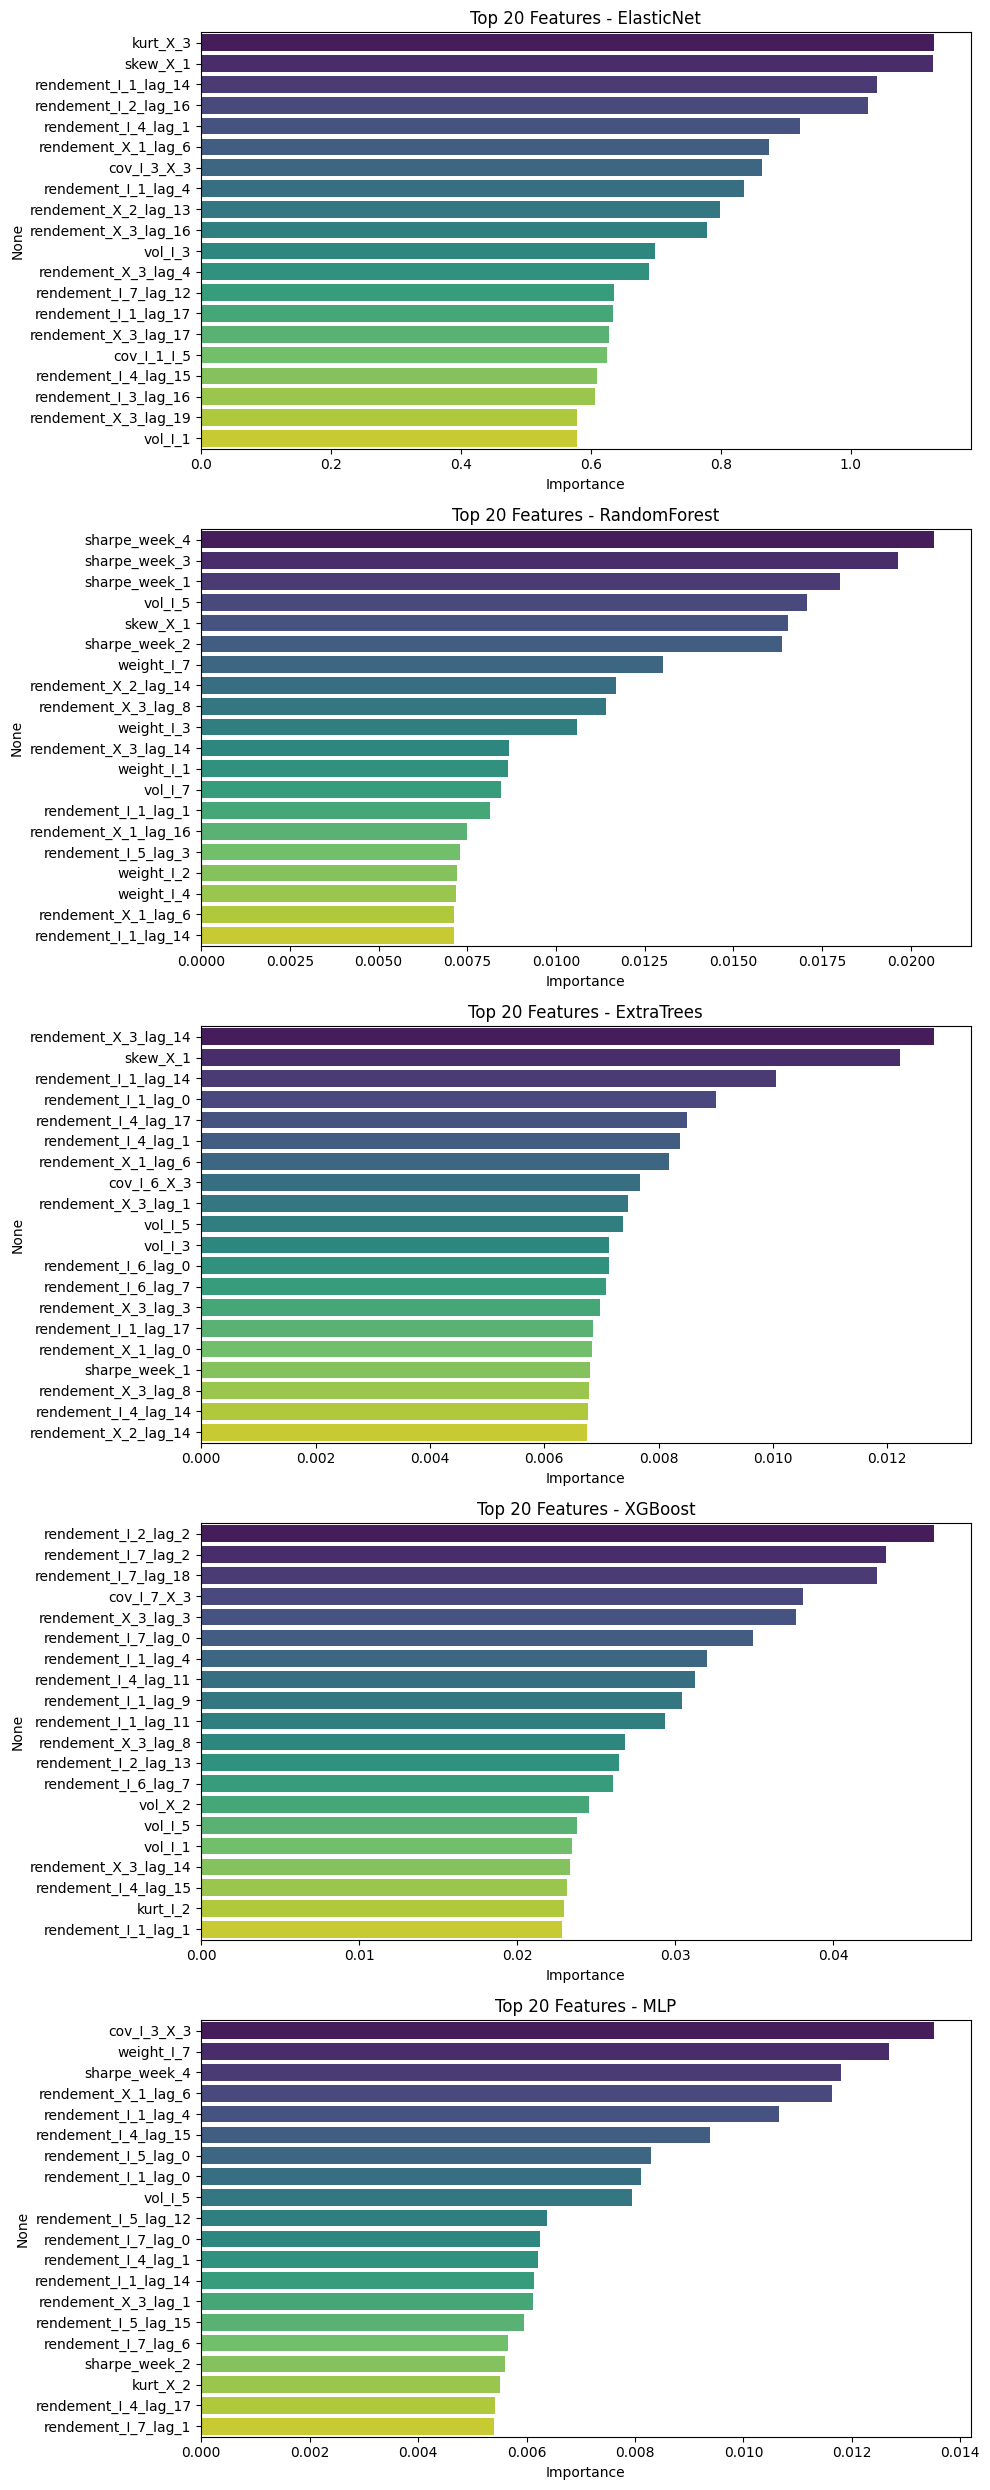

In [ ]:


# Wrapper pour MLP 
class WrappedMLP(BaseEstimator, RegressorMixin):
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
        self.is_fitted_ = True
    def fit(self, X, y=None): return self
    def predict(self, X):
        X_s = self.scaler.transform(X)
        return self.model.predict(X_s, verbose=0).ravel()
    def __sklearn_is_fitted__(self): return True

model_features = {}

# 1. ElasticNet
if 'final' in globals():
    enet_model = final.named_steps['model']
    # Gestion de pipeline imbriqué ou simple modele
    est = enet_model.named_steps['model'] if hasattr(enet_model, 'named_steps') else enet_model
    coefs = est.coef_
    model_features['ElasticNet'] = pd.Series(np.abs(coefs), index=X_train.columns).sort_values(ascending=False).head(20)

# 2. Arbres (RF, ExtraTrees, XGBoost)
for name, var_name in [('RandomForest', 'rf_final'), ('ExtraTrees', 'etr_final'), ('XGBoost', 'xgb_final')]:
    if var_name in globals():
        m = globals()[var_name]
        est = m.named_steps['model'] if hasattr(m, 'named_steps') else m
        imps = pd.Series(est.feature_importances_, index=X_train.columns)
        model_features[name] = imps.sort_values(ascending=False).head(20)

# 3. MLP (Permutation Importance)
if 'model_final' in globals() and 'scaler_final' in globals():
    print("Calcul features MLP (Permutation Importance)...")
    wrapped_model = WrappedMLP(model_final, scaler_final)
    r = permutation_importance(wrapped_model, X_val, yva, n_repeats=5, random_state=42, n_jobs=1)
    model_features['MLP'] = pd.Series(r.importances_mean, index=X_train.columns).sort_values(ascending=False).head(20)

# 4. Affichage
if len(model_features) > 0:
    n_models = len(model_features)
    fig, axes = plt.subplots(n_models, 1, figsize=(10, 5 * n_models))
    if n_models == 1: axes = [axes]
    
    for i, (name, top_feat) in enumerate(model_features.items()):
        sns.barplot(x=top_feat.values, y=top_feat.index, ax=axes[i], palette="viridis")
        axes[i].set_title(f"Top 20 Features - {name}")
        axes[i].set_xlabel("Importance")
    
    plt.tight_layout()
    plt.show()

Comme prévu et discuté précedemment, le signal est diffus dans toutes les features, aucune n'est prépondérante. Ces résultats le montre car tous les poids sont équilibrés et changent d'un modèle à l'autre (même si les rendements reviennent souvent).